# Load

In [6]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
from scipy.sparse import diags
from scipy.io import mmwrite
from scipy import sparse
from scipy.optimize import fsolve,minimize
from tqdm import tqdm
from pathlib import Path
from typing import Union, Optional
import pickle
import seaborn as sns

In [3]:
from scDenorm.denorm import *

In [4]:
from scAnnot.tools import *

In [5]:
import matplotlib as mpl
sc.set_figure_params(scanpy=True, fontsize=14,facecolor=None,frameon=False,transparent=True)
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = False

In [7]:
def solve_bc(p,y1,y2):
    return sum((np.exp(y2*np.log(p[0]))-2*np.exp(y1*np.log(p[0]))+p[1])**2)

In [7]:
def solve_bc(p,y1,y2):
    return sum((np.power(p[0],y2)-2*np.power(p[0],y1)+p[1])**2)

In [37]:
def solve_bc(p,y1,y2):
    return sum(((np.power(p[0],y2)-p[1])/(np.power(p[0],y1)-p[1])-2)**2)

# Benchmark

In [7]:
brain_df=pd.read_csv('data/Main Data Sources - Brain.csv')

In [8]:
brain_df.columns

Index(['human_brain_fetal_Braun_2022_10x', 'id', 'Project', 'a', 'Year',
       'Title', 'Ref', '#Cell Reported', 'Download Link', 'Accession code',
       'JIE-mark', 'Disease', 'Type', 'Tissue (Original Name)', 'Region1',
       'Region 2', 'Region 3', 'Cell Source', 'Organism', 'Technology', 'en',
       'Donwload Notes', 'Download', '#Cell Downloaded', 'rawdata path',
       'h5ad', 'h5ad path', 'Conversion Notes', 'tsv ', 'metadata',
       '4000 gene', 'Unnamed: 31', 'fine anno', 'manul anno', 'need anno',
       '注释情况核对', 'Contact', 'QC', '#gene', 'In-use', 'metadata.1'],
      dtype='object')

In [29]:
references = [
    "Agarwal et al NCommunications 2020",
    "Yu et al NNeuroscience 2021",
    "Revah et al Nature 2022",
    "Kracht et al Science 2020",
    "Batiuk et al NCommunications 2020",
    "Soldatov et al Science 2019",
    "Lake et al NBT 2017",
    "Wu et al Neuron 2017",
    "Yuzwa et al CReports 2017"
]

In [30]:
brain_df['rawdata path'][brain_df.id.isin(references)]

19        human_brain_FC_Cerebellum_Lake_2017_snDrop-Seq
20     /home/huang_ziliang/project/brain/data/public/...
56                  public/human_brain_fetal_Yu_2021_10x
58     /home/huang_ziliang/project/brain/data/public/...
71                  human_brain_organoids_Revah_2022_10x
154                mouse_brain_Amygdala_Wu_2017_Drop-seq
175      mouse_brain_EmbryonicCortex_Yuzwa_2017_Drop-Seq
194             mouse_brain_Astrocytes_Batiuk_2020_smart
219     mouse_brain_NeuralCrest_Soldatov_2019_Smart-seq2
Name: rawdata path, dtype: object

In [31]:
bench_df=brain_df[brain_df.id.isin(references)]

In [32]:
bench_df.index=list(bench_df.id)

In [33]:
bench_df

human_brain_fetal_Braun_2022_10x  \
Lake et al NBT 2017                                           1905.0   
Agarwal et al NCommunications 2020                            1905.0   
Yu et al NNeuroscience 2021                                   1905.0   
Kracht et al Science 2020                                     1905.0   
Revah et al Nature 2022                                          NaN   
Wu et al Neuron 2017                                          2017.0   
Yuzwa et al CReports 2017                                     2017.0   
Batiuk et al NCommunications 2020                             2020.0   
Soldatov et al Science 2019                                   2019.0   

                                                                    id  \
Lake et al NBT 2017                                Lake et al NBT 2017   
Agarwal et al NCommunications 2020  Agarwal et al NCommunications 2020   
Yu et al NNeuroscience 2021                Yu et al NNeuroscience 2021   
Kracht et al Science 2020                    Kracht et al Science 2020   
Revah et al Nature 2022                        Revah et al Nature 2022   
Wu et al Neuron 2017                              Wu et al Neuron 2017   
Yuzwa et al CReports 2017                    Yuzwa et al CReports 2017   
Batiuk et al NCommunications 2020    Batiuk et al NCommunications 2020   
Soldatov et al Science 2019                Soldatov et al Science 2019   

                                   Project                              a  \
Lake et al NBT 2017                    NaN                 Lake et al NBT   
Agarwal et al NCommunications 2020     NaN  Agarwal et al NCommunications   
Yu et al NNeuroscience 2021            NaN         Yu et al NNeuroscience   
Kracht et al Science 2020              NaN           Kracht et al Science   
Revah et al Nature 2022                NaN             Revah et al Nature   
Wu et al Neuron 2017                   NaN                Wu et al Neuron   
Yuzwa et al CReports 2017              NaN           Yuzwa et al CReports   
Batiuk et al NCommunications 2020      NaN   Batiuk et al NCommunications   
Soldatov et al Science 2019            NaN         Soldatov et al Science   

                                          Year  \
Lake et al NBT 2017                       2017   
Agarwal et al NCommunications 2020        2020   
Yu et al NNeuroscience 2021               2021   
Kracht et al Science 2020                 2020   
Revah et al Nature 2022                   2022   
Wu et al Neuron 2017                10/13/2017   
Yuzwa et al CReports 2017           12/26/2017   
Batiuk et al NCommunications 2020     3/5/2020   
Soldatov et al Science 2019           6/7/2019   

                                                                                Title  \
Lake et al NBT 2017                 Integrative single-cell analysis of transcript...   
Agarwal et al NCommunications 2020  A single-cell atlas of the human substantia ni...   
Yu et al NNeuroscience 2021         Interneuron origin and molecular diversity in ...   
Kracht et al Science 2020           Human fetal microglia acquire homeostatic immu...   
Revah et al Nature 2022             Maturation and circuit integration of transpla...   
Wu et al Neuron 2017                                                              NaN   
Yuzwa et al CReports 2017                                                         NaN   
Batiuk et al NCommunications 2020                                                 NaN   
Soldatov et al Science 2019                                                       NaN   

                                                                                  Ref  \
Lake et al NBT 2017                                                  10.1038/nbt.4038   
Agarwal et al NCommunications 2020                         10.1038/s41467-020-17876-0   
Yu et al NNeuroscience 2021                                10.1038/s41593-021-00940-3   
Kracht et al Science 2020                              

In [34]:
bench_df=bench_df.loc[references,:]

In [21]:
bench_df.columns

Index(['human_brain_fetal_Braun_2022_10x', 'id', 'Project', 'a', 'Year',
       'Title', 'Ref', '#Cell Reported', 'Download Link', 'Accession code',
       'JIE-mark', 'Disease', 'Type', 'Tissue (Original Name)', 'Region1',
       'Region 2', 'Region 3', 'Cell Source', 'Organism', 'Technology', 'en',
       'Donwload Notes', 'Download', '#Cell Downloaded', 'rawdata path',
       'h5ad', 'h5ad path', 'Conversion Notes', 'tsv ', 'metadata',
       '4000 gene', 'Unnamed: 31', 'fine anno', 'manul anno', 'need anno',
       '注释情况核对', 'Contact', 'QC', '#gene', 'In-use', 'metadata.1'],
      dtype='object')

In [41]:
bench_df[['id', 'Ref', 'Technology']]

id  \
Agarwal et al NCommunications 2020  Agarwal et al NCommunications 2020   
Yu et al NNeuroscience 2021                Yu et al NNeuroscience 2021   
Revah et al Nature 2022                        Revah et al Nature 2022   
Kracht et al Science 2020                    Kracht et al Science 2020   
Batiuk et al NCommunications 2020    Batiuk et al NCommunications 2020   
Soldatov et al Science 2019                Soldatov et al Science 2019   
Lake et al NBT 2017                                Lake et al NBT 2017   
Wu et al Neuron 2017                              Wu et al Neuron 2017   
Yuzwa et al CReports 2017                    Yuzwa et al CReports 2017   

                                                                                  Ref  \
Agarwal et al NCommunications 2020                         10.1038/s41467-020-17876-0   
Yu et al NNeuroscience 2021                                10.1038/s41593-021-00940-3   
Revah et al Nature 2022             https://www.nature.com/articles/s41586-022-052...   
Kracht et al Science 2020                                     10.1126/science.aba5906   
Batiuk et al NCommunications 2020                          10.1038/s41467-019-14198-8   
Soldatov et al Science 2019                                   10.1126/science.aas9536   
Lake et al NBT 2017                                                  10.1038/nbt.4038   
Wu et al Neuron 2017                                     10.1016/j.neuron.2017.09.026   
Yuzwa et al CReports 2017                                10.1016/j.celrep.2017.12.017   

                                    Technology  
Agarwal et al NCommunications 2020    Chromium  
Yu et al NNeuroscience 2021           Chromium  
Revah et al Nature 2022               Chromium  
Kracht et al Science 2020           Smart-seq2  
Batiuk et al NCommunications 2020   Smart-seq2  
Soldatov et al Science 2019         Smart-seq2  
Lake et al NBT 2017                   Drop-seq  
Wu et al Neuron 2017                  Drop-seq  
Yuzwa et al CReports 2017             Drop-seq

In [62]:
df_drop.T

0         1         2         3  \
HindbrainCerebellum_2017_DropSeq  0.998682  0.998377  0.997110  0.988793   
Lake_2017_snDrop-Seq              1.000000  0.999090  0.962393  0.845336   
Saunders_2018_Drop-Seq            0.999970  0.988063  0.917479  0.798110   
Zywitza_2018_Drop-seq             0.999463  0.993972  0.954707  0.861850   
Wu_2017_Drop-seq                  1.000000  1.000000  0.999420  0.988781   
Yuzwa_2017_Drop-Seq               1.000000  1.000000  0.999061  0.989671   
x                                 1.000000  2.000000  3.000000  4.000000   

                                         4         5         6         7  \
HindbrainCerebellum_2017_DropSeq  0.962018  0.922262  0.875456  0.831034   
Lake_2017_snDrop-Seq              0.684806  0.538266  0.420237  0.327520   
Saunders_2018_Drop-Seq            0.662510  0.535944  0.422973  0.328722   
Zywitza_2018_Drop-seq             0.721552  0.572956  0.444178  0.334847   
Wu_2017_Drop-seq                  0.941680  0.841143  0.707674  0.562987   
Yuzwa_2017_Drop-Seq               0.963693  0.904069  0.823161  0.725196   
x                                 5.000000  6.000000  7.000000  8.000000   

                                         8          9  
HindbrainCerebellum_2017_DropSeq  0.787931   0.745538  
Lake_2017_snDrop-Seq              0.253685   0.189135  
Saunders_2018_Drop-Seq            0.251948   0.189686  
Zywitza_2018_Drop-seq             0.245912   0.179397  
Wu_2017_Drop-seq                  0.429421   0.319455  
Yuzwa_2017_Drop-Seq               0.621440   0.520031  
x                                 9.000000  10.000000

In [38]:
bench_paths=['/home/huang_ziliang/project/brain/data/public/human_brain_FC_Agarwal_2020_10x/h5/annot.h5ad',
 '/home/huang_ziliang/project/brain/data/public/human_brain_fetal_Yu_2021_10x/h5/annot.h5ad',
 '/home/huang_ziliang/project/brain/data/public/human_brain_organoids_Revah_2022_10x/h5/annot.h5ad',
 '/home/huang_ziliang/project/brain/data/public/human_brain_Microglia_Kracht_2020_Smartseq2/h5/annot.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_Astrocytes_Batiuk_2020_smart/h5/mouse_brain_Astrocytes_Batiuk_2020_smart.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_NeuralCrest_Soldatov_2019_Smart-seq2/h5/mouse_brain_NeuralCrest_Soldatov_2019_Smart-seq2.h5',
 '/home/huang_ziliang/project/brain/data/public/human_brain_FC_Cerebellum_Lake_2017_snDrop-Seq/h5/annot.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_Amygdala_Wu_2017_Drop-seq/h5/mouse_brain_Amygdala_Wu_2017_Drop-seq.h5ad',
 '/home/huang_ziliang/project/brain/data/public/mouse_brain_EmbryonicCortex_Yuzwa_2017_Drop-Seq/h5/mouse_brain_EmbryonicCortex_Yuzwa_2017_Drop-Seq.h5ad']

In [39]:
ads=[sc.read(f)[:1000] for f in bench_paths]

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is d

In [86]:
with open('data/results/bench_diff_cond.pickle', 'wb') as handle:
    pickle.dump(ads, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Data

In [39]:
with open(f'data/results/bench_diff_cond.pickle', 'rb') as handle:
    ads=pickle.load(handle)

In [40]:
len(ads)

9

In [11]:
references = [
    "Agarwal et al NCommunications 2020",
    "Yu et al NNeuroscience 2021",
    "Revah et al Nature 2022",
    "Kracht et al Science 2020",
    "Batiuk et al NCommunications 2020",
    "Soldatov et al Science 2019",
    "Lake et al NBT 2017",
    "Wu et al Neuron 2017",
    "Yuzwa et al CReports 2017"
]

## Sup Figure 1 - the relationship between the mean and variance of genes before normalization

### before normlization

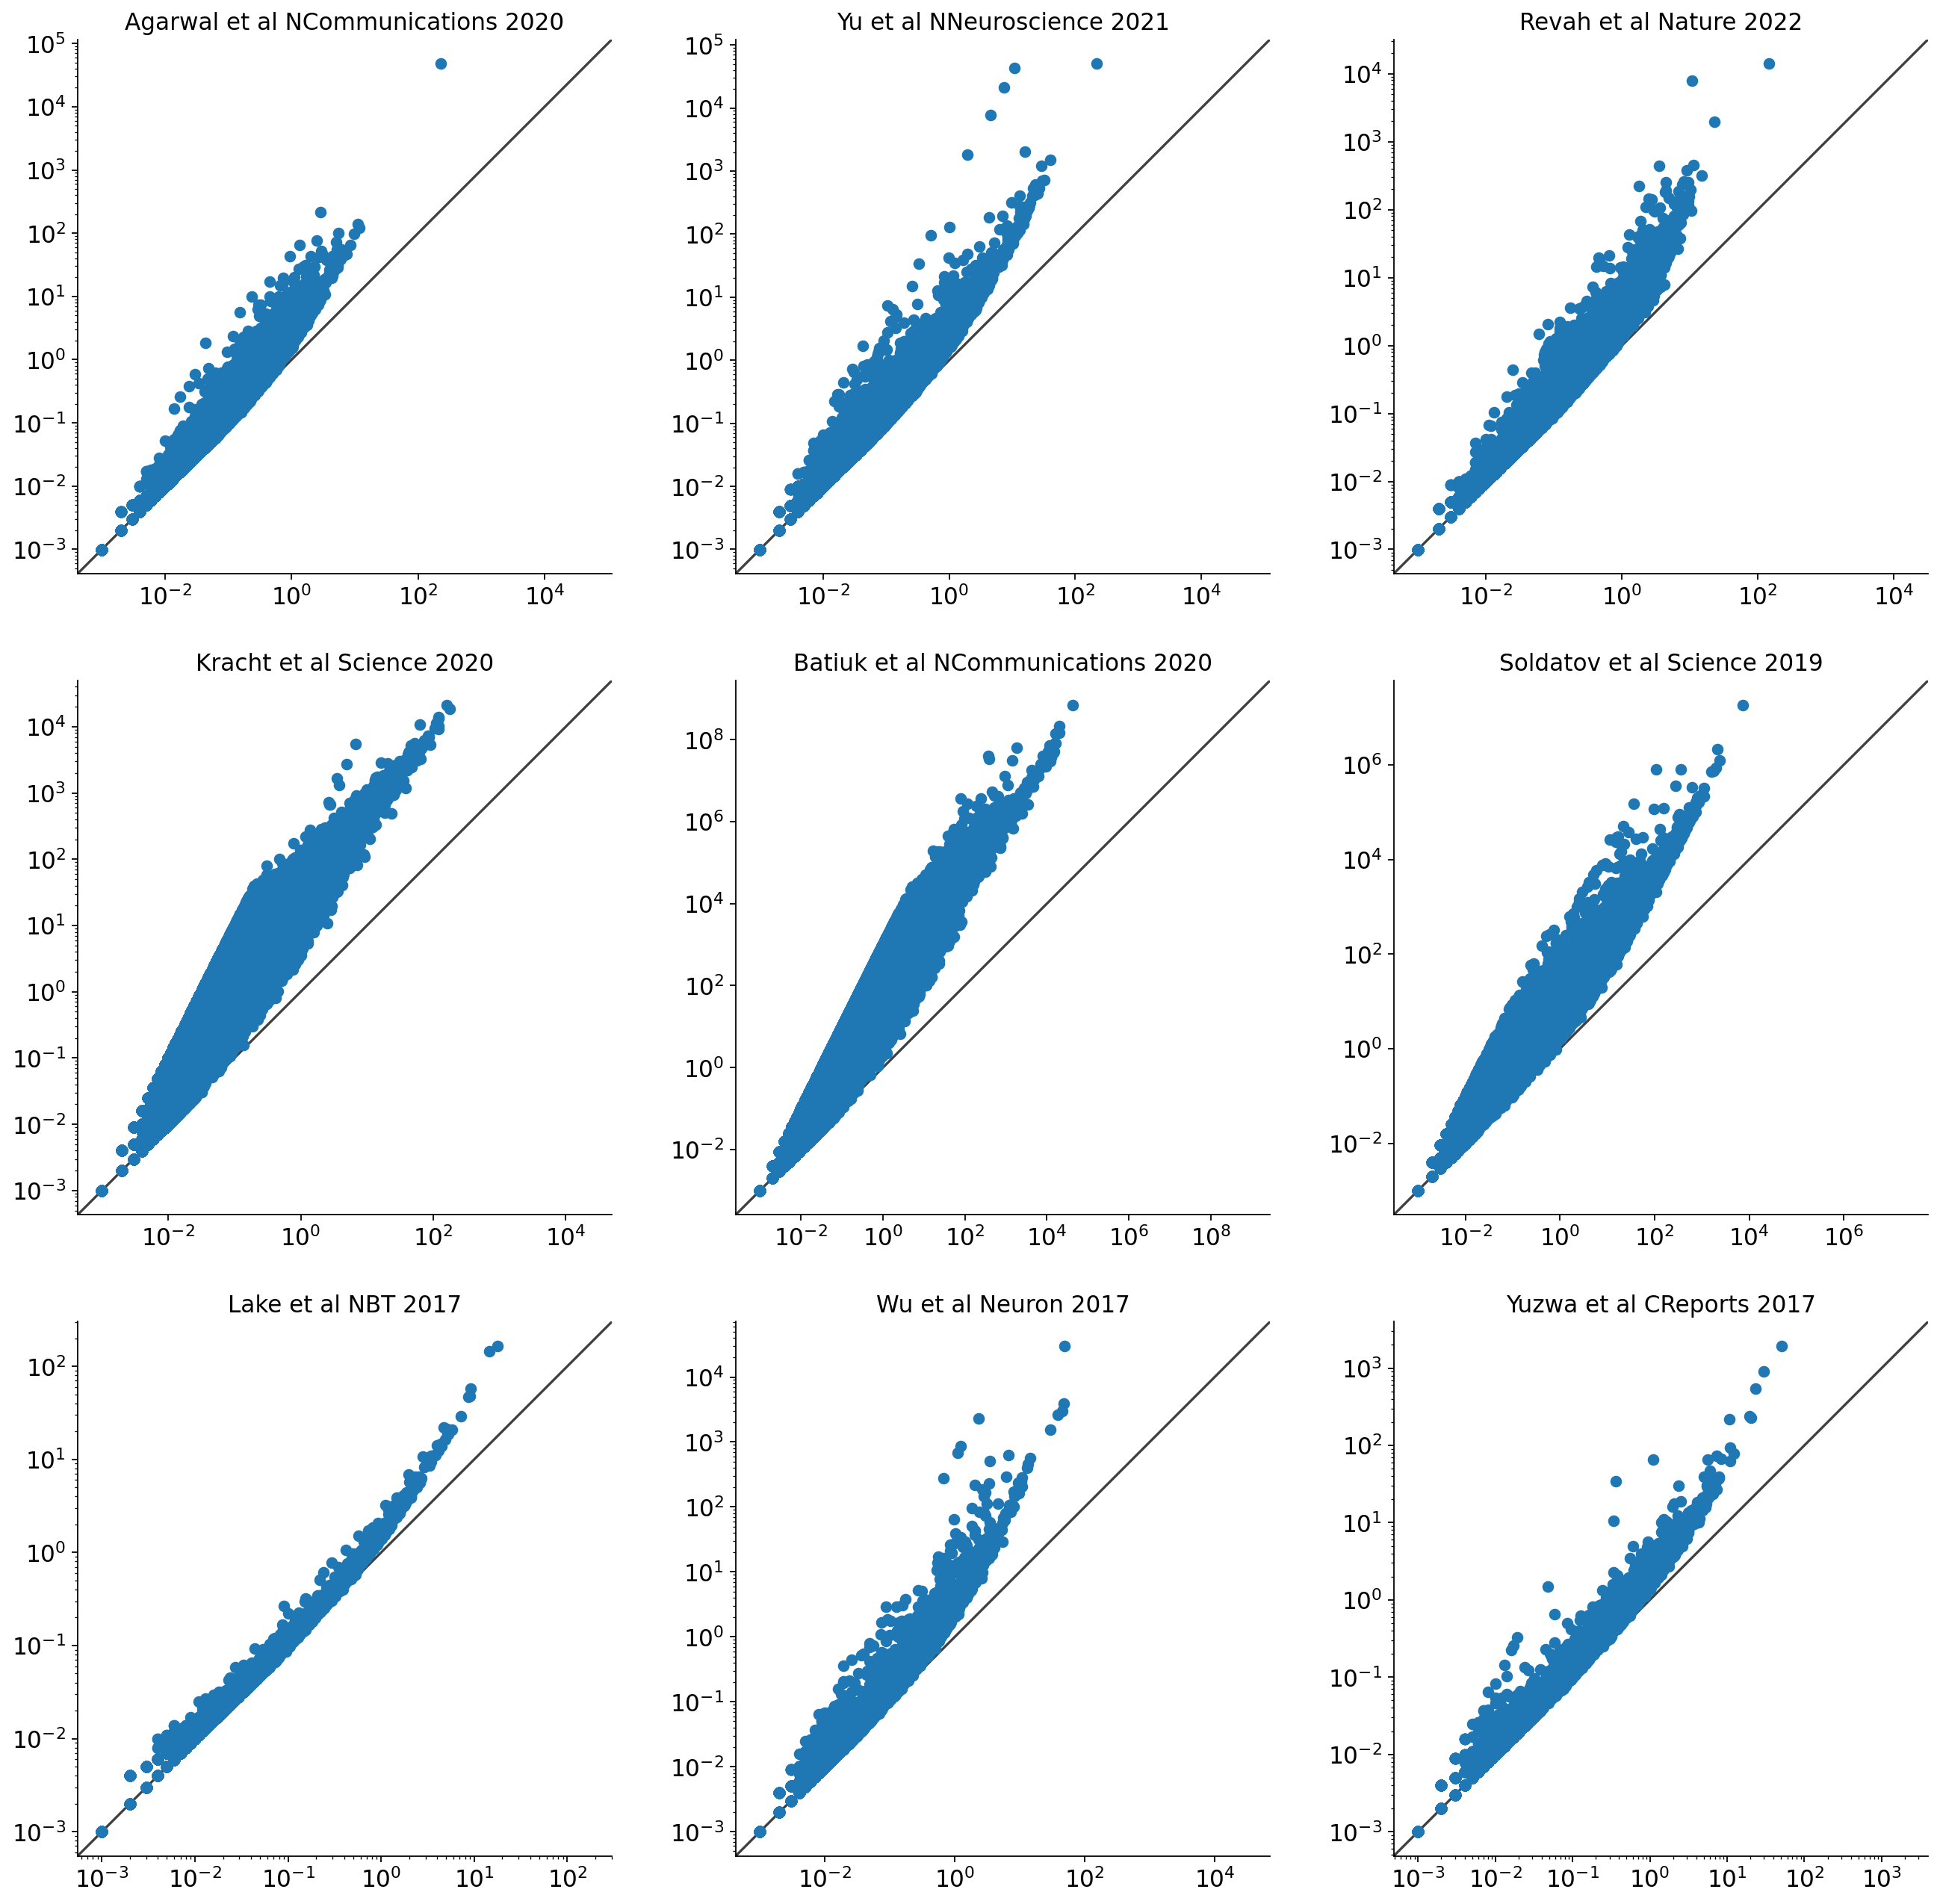

In [12]:
fig, axs = plt.subplots(3,3,figsize=(20,20))
axs = axs.ravel()
for i,ad in enumerate(ads):
    smtx=ad.X
    cmean = np.array(smtx.mean(0))
    cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)

    ax=axs[i]
    ax.loglog()
    ax.scatter(cmean, cvar)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.title.set_text(references[i])
plt.savefig('figures/Sup4_figure_1.pdf',dpi=600,format='pdf', transparent=True)
plt.show()

## Sup Figure 2 - the relationship between the mean and variance of genes after normalization

### after normlization

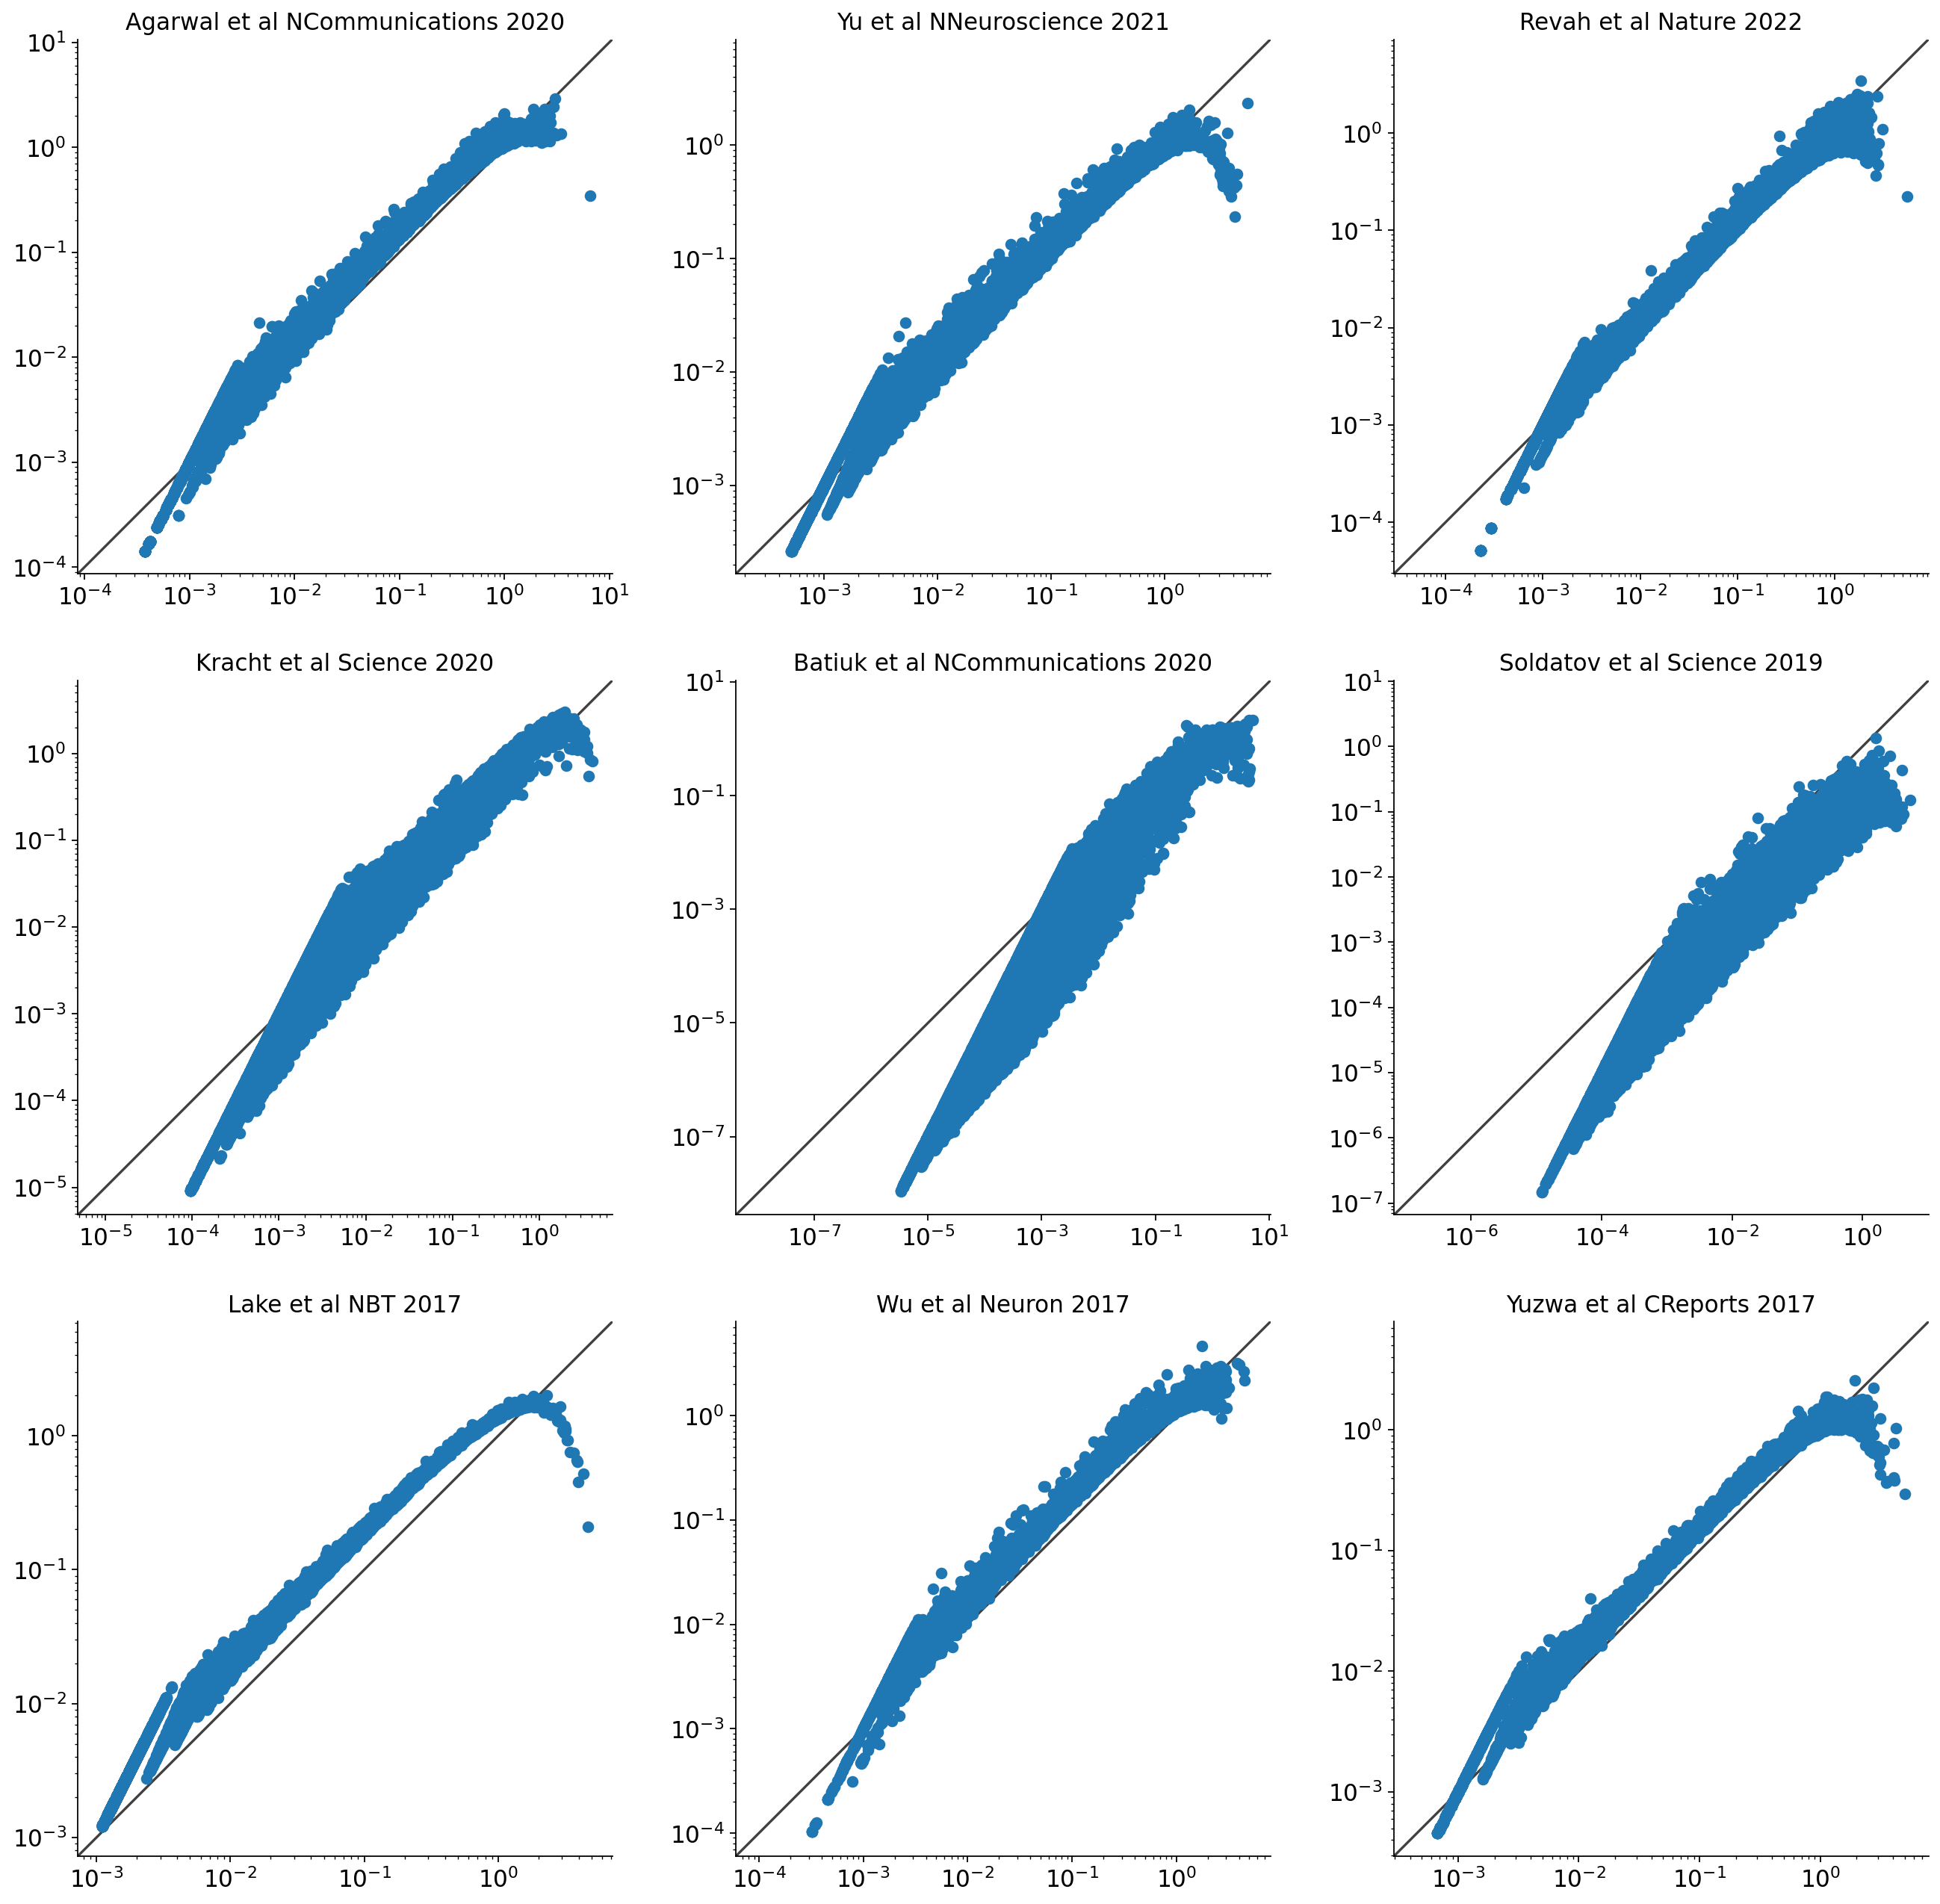

In [13]:
fig, axs = plt.subplots(3,3,figsize=(20,20))
axs = axs.ravel()
for i,ad in enumerate(ads):
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)
    smtx=ad.X
    cmean = np.array(smtx.mean(0))
    cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)

    ax=axs[i]
    ax.loglog()
    ax.scatter(cmean, cvar)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.title.set_text(references[i])
plt.savefig('figures/Sup4_figure_2.pdf',dpi=600,format='pdf', transparent=True)
plt.show()

##  Sup Figure 3 - the residual distribution of data restoration

### restore errors with total count 1e4, 1e5, 1e6 and log transformation with base e, 2, 10

In [41]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/human_brain_Glioblastoma_Darmanis_2017_SmartSeq2/h5/ss2_annot.h5ad')

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [42]:
ads[5]=ad[:1000]

In [94]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/mouse_brain_mycroglia_myeloid_Li_2018_smart/h5/mouse_brain_mycroglia_myeloid_Li_2018_smart.h5ad')

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [95]:
ad=ad[:,pd.DataFrame(ad.X).isna().sum()==0].copy()

In [96]:
ad.X=sparse.csr_matrix(ad.X)

In [97]:
ads[4]=ad[:1000]

In [98]:
ad=ad[:1000].copy()

In [99]:
ts=1e4
b=np.e

In [100]:
ad.layers['count']=ad.X.copy()
sc.pp.normalize_total(ad, target_sum=ts)
sc.pp.log1p(ad,base=b)
new_ad=scdenorm(ad,cutoff=0.01)
res=new_ad.X.data-new_ad.layers['count'].data

b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1768.67it/s]


In [106]:
new_ad.X.data=new_ad.X.data-new_ad.layers['count'].data

In [136]:
(new_ad.X.todense()>0.05)[95:96].sum(axis=1).sum()

1

In [130]:
(new_ad.X.todense()>0.05)[608:609].sum(axis=1).sum()

1

In [138]:
((new_ad.X.todense()<-0.05).sum(axis=1)>0) or ((new_ad.X.todense()>0.05).sum(axis=1)>0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### sum(res>0.05)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f0fd9044460>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f0fd9044400>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f0fd90257f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f0fd90252b0>}

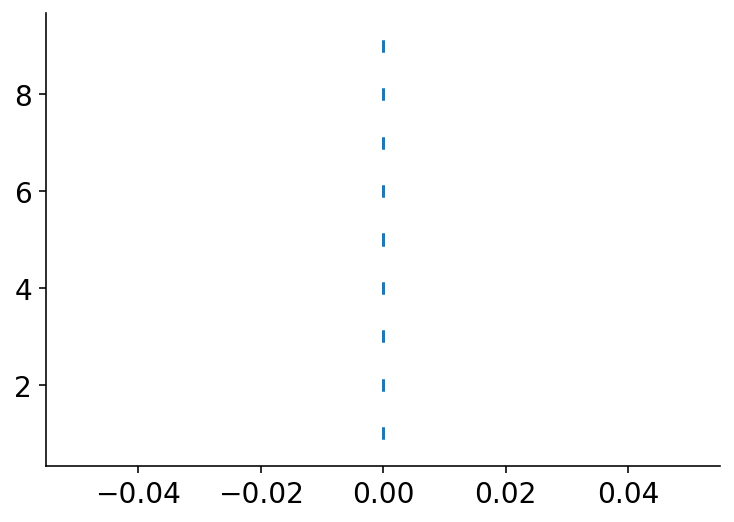

In [101]:
plt.violinplot(ress.values(),vert=False)

In [142]:
rs=[]
for ts in [1e4,1e5,1e6]:
    for b in [np.e,2,10]:
        ress={}
        for i,adata in zip(references,ads):
            ad=adata.copy()
            ad.layers['count']=ad.X.copy()
            sc.pp.normalize_total(ad, target_sum=ts)
            sc.pp.log1p(ad,base=b)
            new_ad=scdenorm(ad,cutoff=0.01,rint=False)
            res=new_ad.X.data-new_ad.layers['count'].data
            res = res[abs(res)<0.1]
            ress[i]=res
            print(abs(res).sum(),ad.shape,i)
        rs.append(ress)

b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1787.57it/s]


0.14681745 (1000, 33694) Agarwal et al NCommunications 2020
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1788.47it/s]


0.30549037 (1000, 33538) Yu et al NNeuroscience 2021
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1708.39it/s]


5.687180726354768e-10 (1000, 30779) Revah et al Nature 2022
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1834.59it/s]


4.15717 (1000, 44200) Kracht et al Science 2020
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1795.48it/s]


1109.9467 (1000, 23404) Batiuk et al NCommunications 2020
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1766.18it/s]


691.5043 (1000, 23368) Soldatov et al Science 2019
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1821.29it/s]


0.062636375 (1000, 43549) Lake et al NBT 2017
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1813.72it/s]


0.18266594 (1000, 16233) Wu et al Neuron 2017
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1810.05it/s]


0.15659702 (1000, 21201) Yuzwa et al CReports 2017
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1802.14it/s]


0.18295765 (1000, 33694) Agarwal et al NCommunications 2020
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1784.11it/s]


0.37594044 (1000, 33538) Yu et al NNeuroscience 2021
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1712.99it/s]


6.357478987695231e-10 (1000, 30779) Revah et al Nature 2022
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1833.78it/s]


4.5691495 (1000, 44200) Kracht et al Science 2020
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1783.11it/s]


1109.5831 (1000, 23404) Batiuk et al NCommunications 2020
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1768.95it/s]


691.9012 (1000, 23368) Soldatov et al Science 2019
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1826.46it/s]


0.08282232 (1000, 43549) Lake et al NBT 2017
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1813.25it/s]


0.22171211 (1000, 16233) Wu et al Neuron 2017
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1805.23it/s]


0.19967437 (1000, 21201) Yuzwa et al CReports 2017
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1799.60it/s]


0.18152797 (1000, 33694) Agarwal et al NCommunications 2020
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1793.72it/s]


0.3753246 (1000, 33538) Yu et al NNeuroscience 2021
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1716.61it/s]


7.544552760307965e-10 (1000, 30779) Revah et al Nature 2022
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1831.74it/s]


4.5379696 (1000, 44200) Kracht et al Science 2020
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1793.26it/s]


1109.078 (1000, 23404) Batiuk et al NCommunications 2020
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1755.02it/s]


691.7226 (1000, 23368) Soldatov et al Science 2019
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1817.75it/s]


0.082298756 (1000, 43549) Lake et al NBT 2017
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1812.23it/s]


0.23339128 (1000, 16233) Wu et al Neuron 2017
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1808.00it/s]


0.20410717 (1000, 21201) Yuzwa et al CReports 2017
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1786.97it/s]


0.23754656 (1000, 33694) Agarwal et al NCommunications 2020
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1777.97it/s]


0.4575014 (1000, 33538) Yu et al NNeuroscience 2021
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1696.19it/s]


8.180748301001017e-10 (1000, 30779) Revah et al Nature 2022
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1812.42it/s]


3.6463046 (1000, 44200) Kracht et al Science 2020
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1784.80it/s]


150.85864 (1000, 23404) Batiuk et al NCommunications 2020
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1764.08it/s]


88.62896 (1000, 23368) Soldatov et al Science 2019
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1815.23it/s]


0.10732007 (1000, 43549) Lake et al NBT 2017
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1819.18it/s]


0.27448213 (1000, 16233) Wu et al Neuron 2017
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1801.35it/s]


0.2600963 (1000, 21201) Yuzwa et al CReports 2017
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1789.89it/s]


0.30291677 (1000, 33694) Agarwal et al NCommunications 2020
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1756.72it/s]


0.5967617 (1000, 33538) Yu et al NNeuroscience 2021
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1704.26it/s]


9.693387204023907e-10 (1000, 30779) Revah et al Nature 2022
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1831.37it/s]


4.4240623 (1000, 44200) Kracht et al Science 2020
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1793.70it/s]


161.48105 (1000, 23404) Batiuk et al NCommunications 2020
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1756.03it/s]


97.18024 (1000, 23368) Soldatov et al Science 2019
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1838.12it/s]


0.13742483 (1000, 43549) Lake et al NBT 2017
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1814.98it/s]


0.35780632 (1000, 16233) Wu et al Neuron 2017
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1793.80it/s]


0.33185756 (1000, 21201) Yuzwa et al CReports 2017
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1790.39it/s]


0.31718814 (1000, 33694) Agarwal et al NCommunications 2020
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1773.37it/s]


0.6017375 (1000, 33538) Yu et al NNeuroscience 2021
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1707.20it/s]


1.1124985377364283e-09 (1000, 30779) Revah et al Nature 2022
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1830.64it/s]


4.588205 (1000, 44200) Kracht et al Science 2020
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1797.67it/s]


162.23688 (1000, 23404) Batiuk et al NCommunications 2020
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1764.45it/s]


96.54451 (1000, 23368) Soldatov et al Science 2019
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1828.69it/s]


0.14416564 (1000, 43549) Lake et al NBT 2017
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1799.11it/s]


0.36369145 (1000, 16233) Wu et al Neuron 2017
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1797.54it/s]


0.34367943 (1000, 21201) Yuzwa et al CReports 2017
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1791.52it/s]


0.31105423 (1000, 33694) Agarwal et al NCommunications 2020
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1776.80it/s]


0.6589892 (1000, 33538) Yu et al NNeuroscience 2021
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1718.87it/s]


1.1141148004156776e-09 (1000, 30779) Revah et al Nature 2022
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1815.07it/s]


4.8005986 (1000, 44200) Kracht et al Science 2020
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1786.24it/s]


125.962006 (1000, 23404) Batiuk et al NCommunications 2020
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1751.09it/s]


78.82731 (1000, 23368) Soldatov et al Science 2019
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1826.11it/s]


0.13334084 (1000, 43549) Lake et al NBT 2017
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1818.09it/s]


0.38370025 (1000, 16233) Wu et al Neuron 2017
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1790.42it/s]


0.3402189 (1000, 21201) Yuzwa et al CReports 2017
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1797.48it/s]


0.45714557 (1000, 33694) Agarwal et al NCommunications 2020
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1771.15it/s]


0.8826722 (1000, 33538) Yu et al NNeuroscience 2021
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1696.79it/s]


1.4979227858091804e-09 (1000, 30779) Revah et al Nature 2022
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1825.70it/s]


6.2753024 (1000, 44200) Kracht et al Science 2020
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1795.99it/s]


146.36642 (1000, 23404) Batiuk et al NCommunications 2020
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1765.37it/s]


92.357994 (1000, 23368) Soldatov et al Science 2019
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1813.61it/s]


0.19843352 (1000, 43549) Lake et al NBT 2017
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1809.37it/s]


0.53963673 (1000, 16233) Wu et al Neuron 2017
b is 2.718281828459045
b is None
b is 2


100%|██████████| 1000/1000 [00:00<00:00, 1803.97it/s]


0.49019623 (1000, 21201) Yuzwa et al CReports 2017
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1792.78it/s]


0.4427377 (1000, 33694) Agarwal et al NCommunications 2020
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1773.68it/s]


0.8844907 (1000, 33538) Yu et al NNeuroscience 2021
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1689.51it/s]


1.6088431697980354e-09 (1000, 30779) Revah et al Nature 2022
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1822.53it/s]


5.97161 (1000, 44200) Kracht et al Science 2020
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1794.61it/s]


147.08794 (1000, 23404) Batiuk et al NCommunications 2020
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1769.39it/s]


92.4422 (1000, 23368) Soldatov et al Science 2019
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1810.13it/s]


0.18827891 (1000, 43549) Lake et al NBT 2017
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1811.21it/s]


0.525833 (1000, 16233) Wu et al Neuron 2017
b is 2.718281828459045
b is None
b is 2
b is 10


100%|██████████| 1000/1000 [00:00<00:00, 1800.27it/s]


0.47446263 (1000, 21201) Yuzwa et al CReports 2017


In [18]:
import pickle
with open('data/sf4_restore_errors_all.pickle', 'wb') as handle:
    pickle.dump(rs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('data/sf4_restore_errors_all.pickle', 'rb') as handle:
    rs = pickle.load(handle)

In [19]:
titles=[]
for ts in ['1e4','1e5','1e6']:
    for b in ['e','2','10']:
        titles.append(f'{ts} and {b}')

In [20]:
titles

['1e4 and e',
 '1e4 and 2',
 '1e4 and 10',
 '1e5 and e',
 '1e5 and 2',
 '1e5 and 10',
 '1e6 and e',
 '1e6 and 2',
 '1e6 and 10']

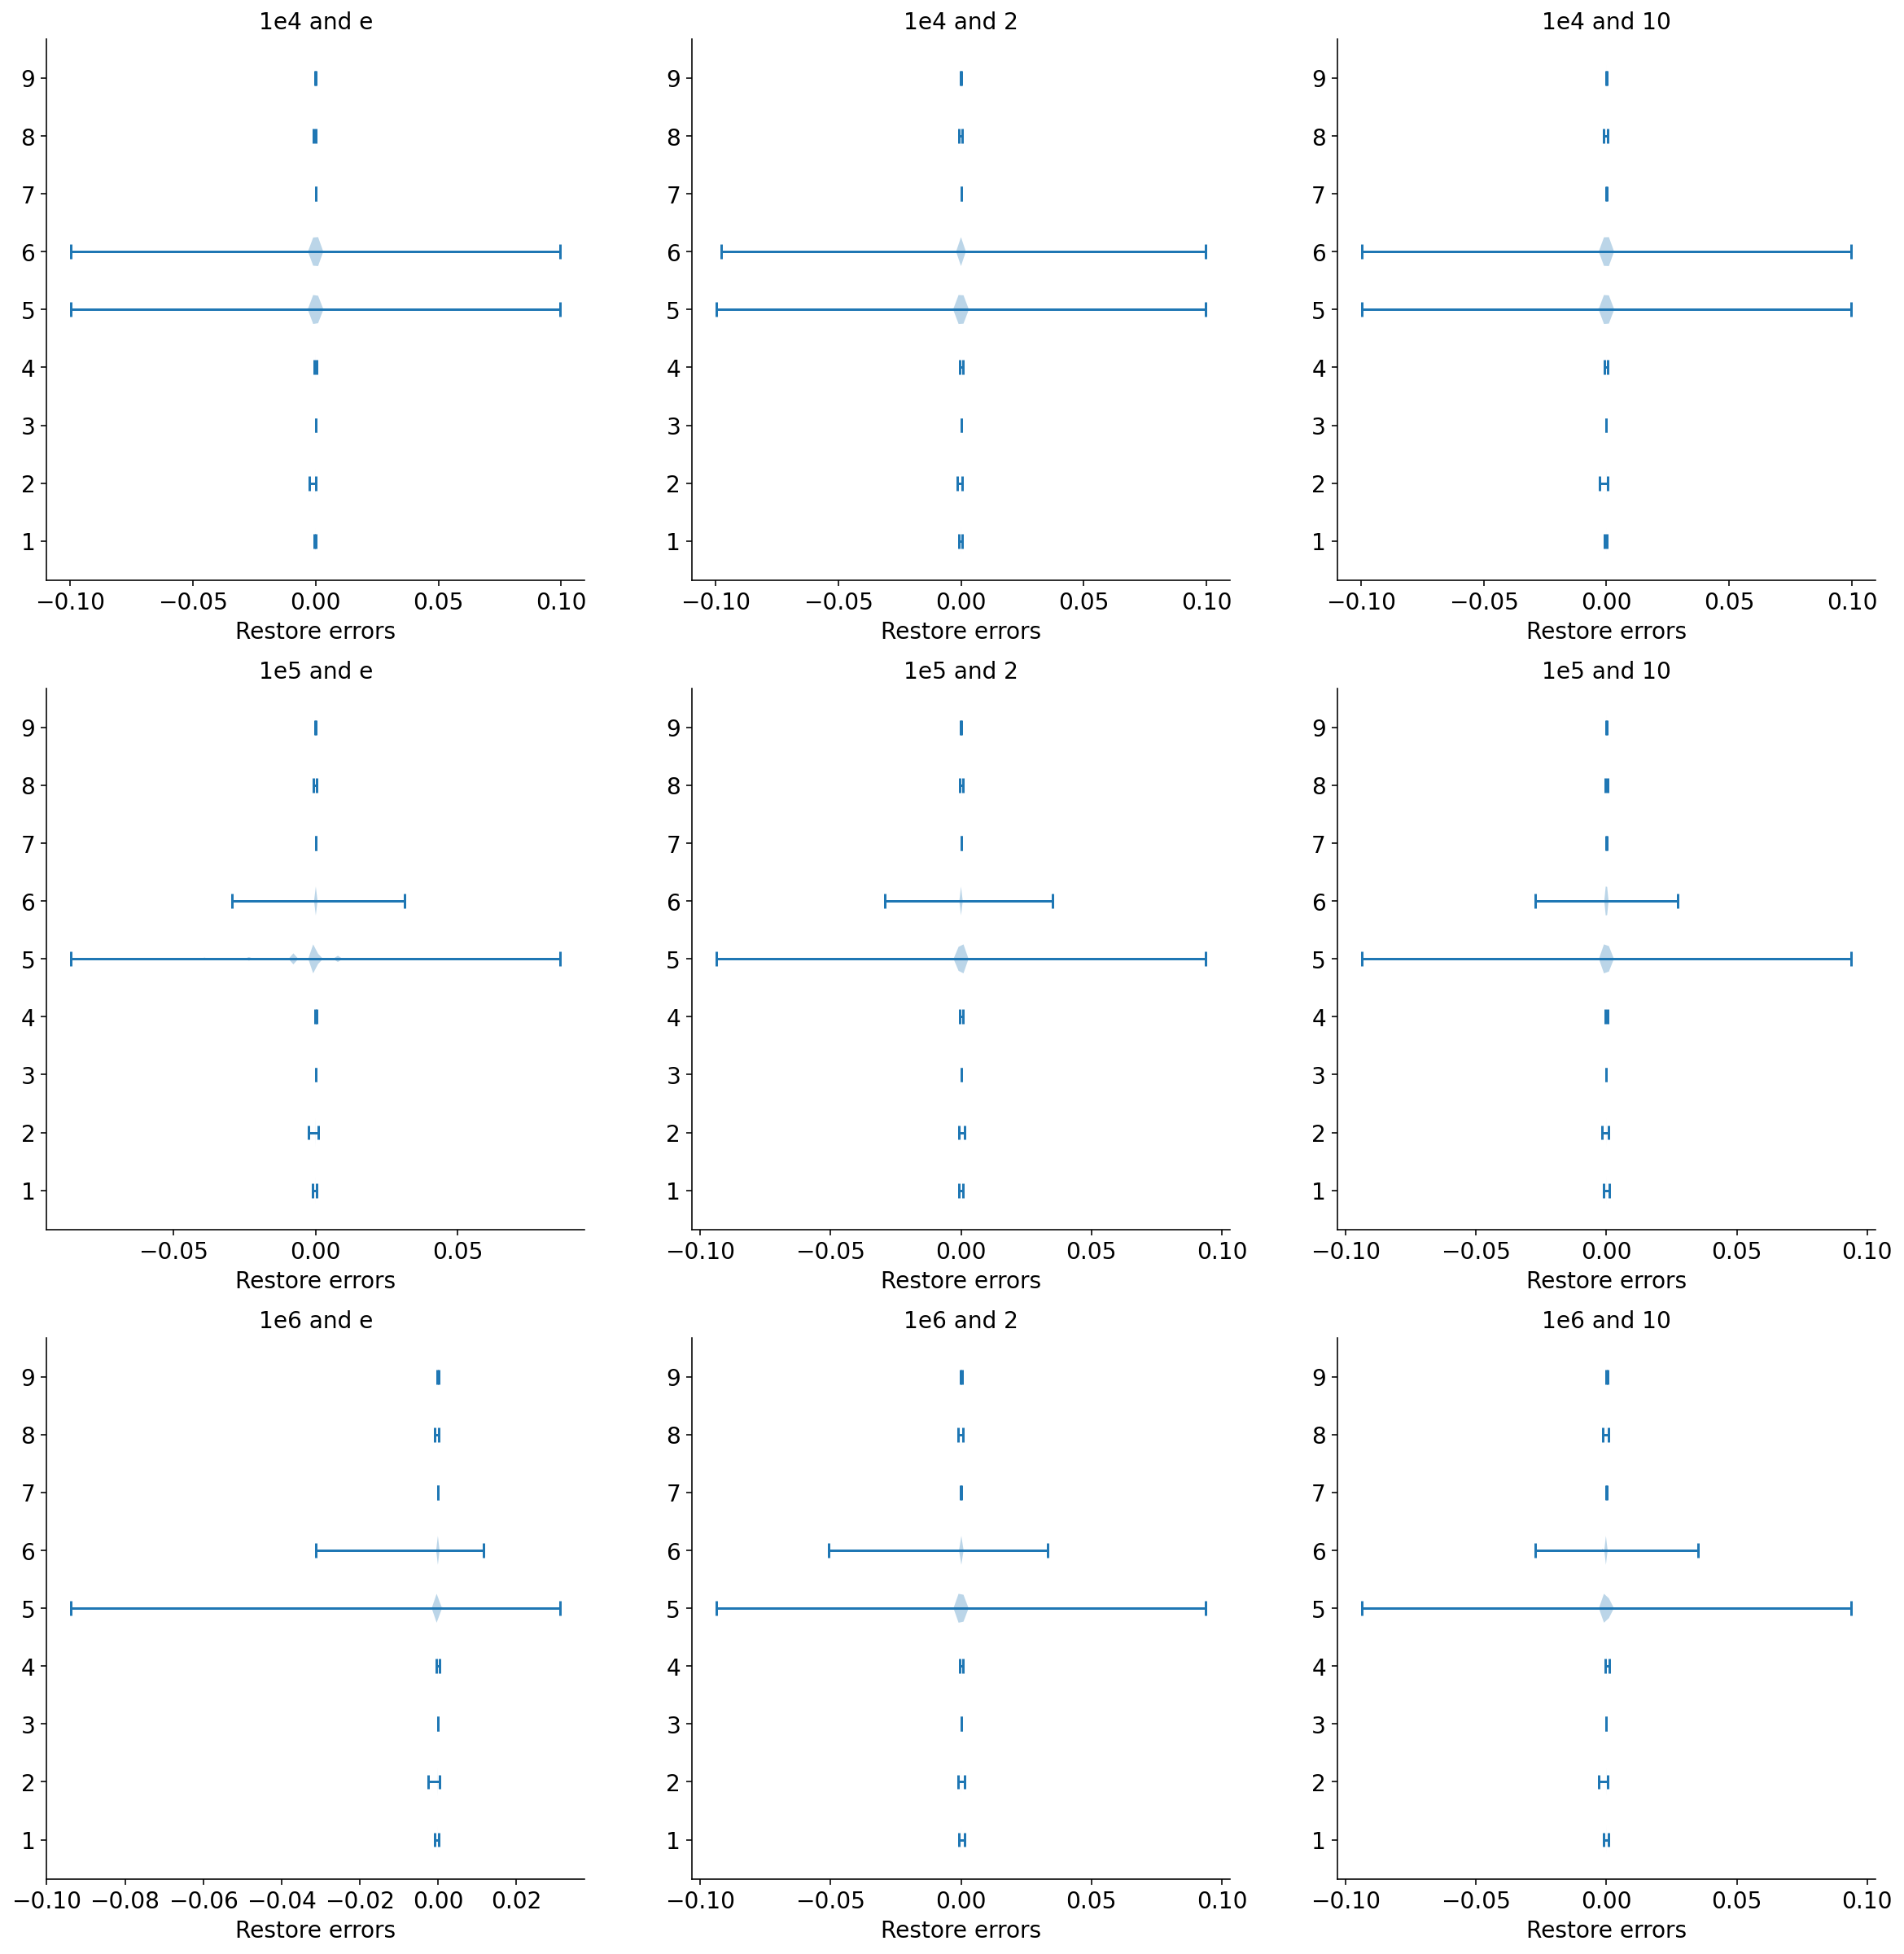

In [143]:
fig, axs = plt.subplots(3,3,figsize=(20,20))
axs = axs.ravel()
for i,ress in enumerate(rs):
    ax=axs[i]
    ax.violinplot(ress.values(),vert=False)
    ax.set_yticks([i+1 for i in range(9)])
    #ax.set_yticklabels(['dataset'+str(10-i) for i in range(10)])
    ax.set_xlabel("Restore errors")
    #ax.set_xlim(-1e-4,1e-4)
    ax.title.set_text(titles[i])
#plt.savefig('figures/Sup_figure_3.pdf',dpi=600,format='pdf', transparent=True)
plt.show()

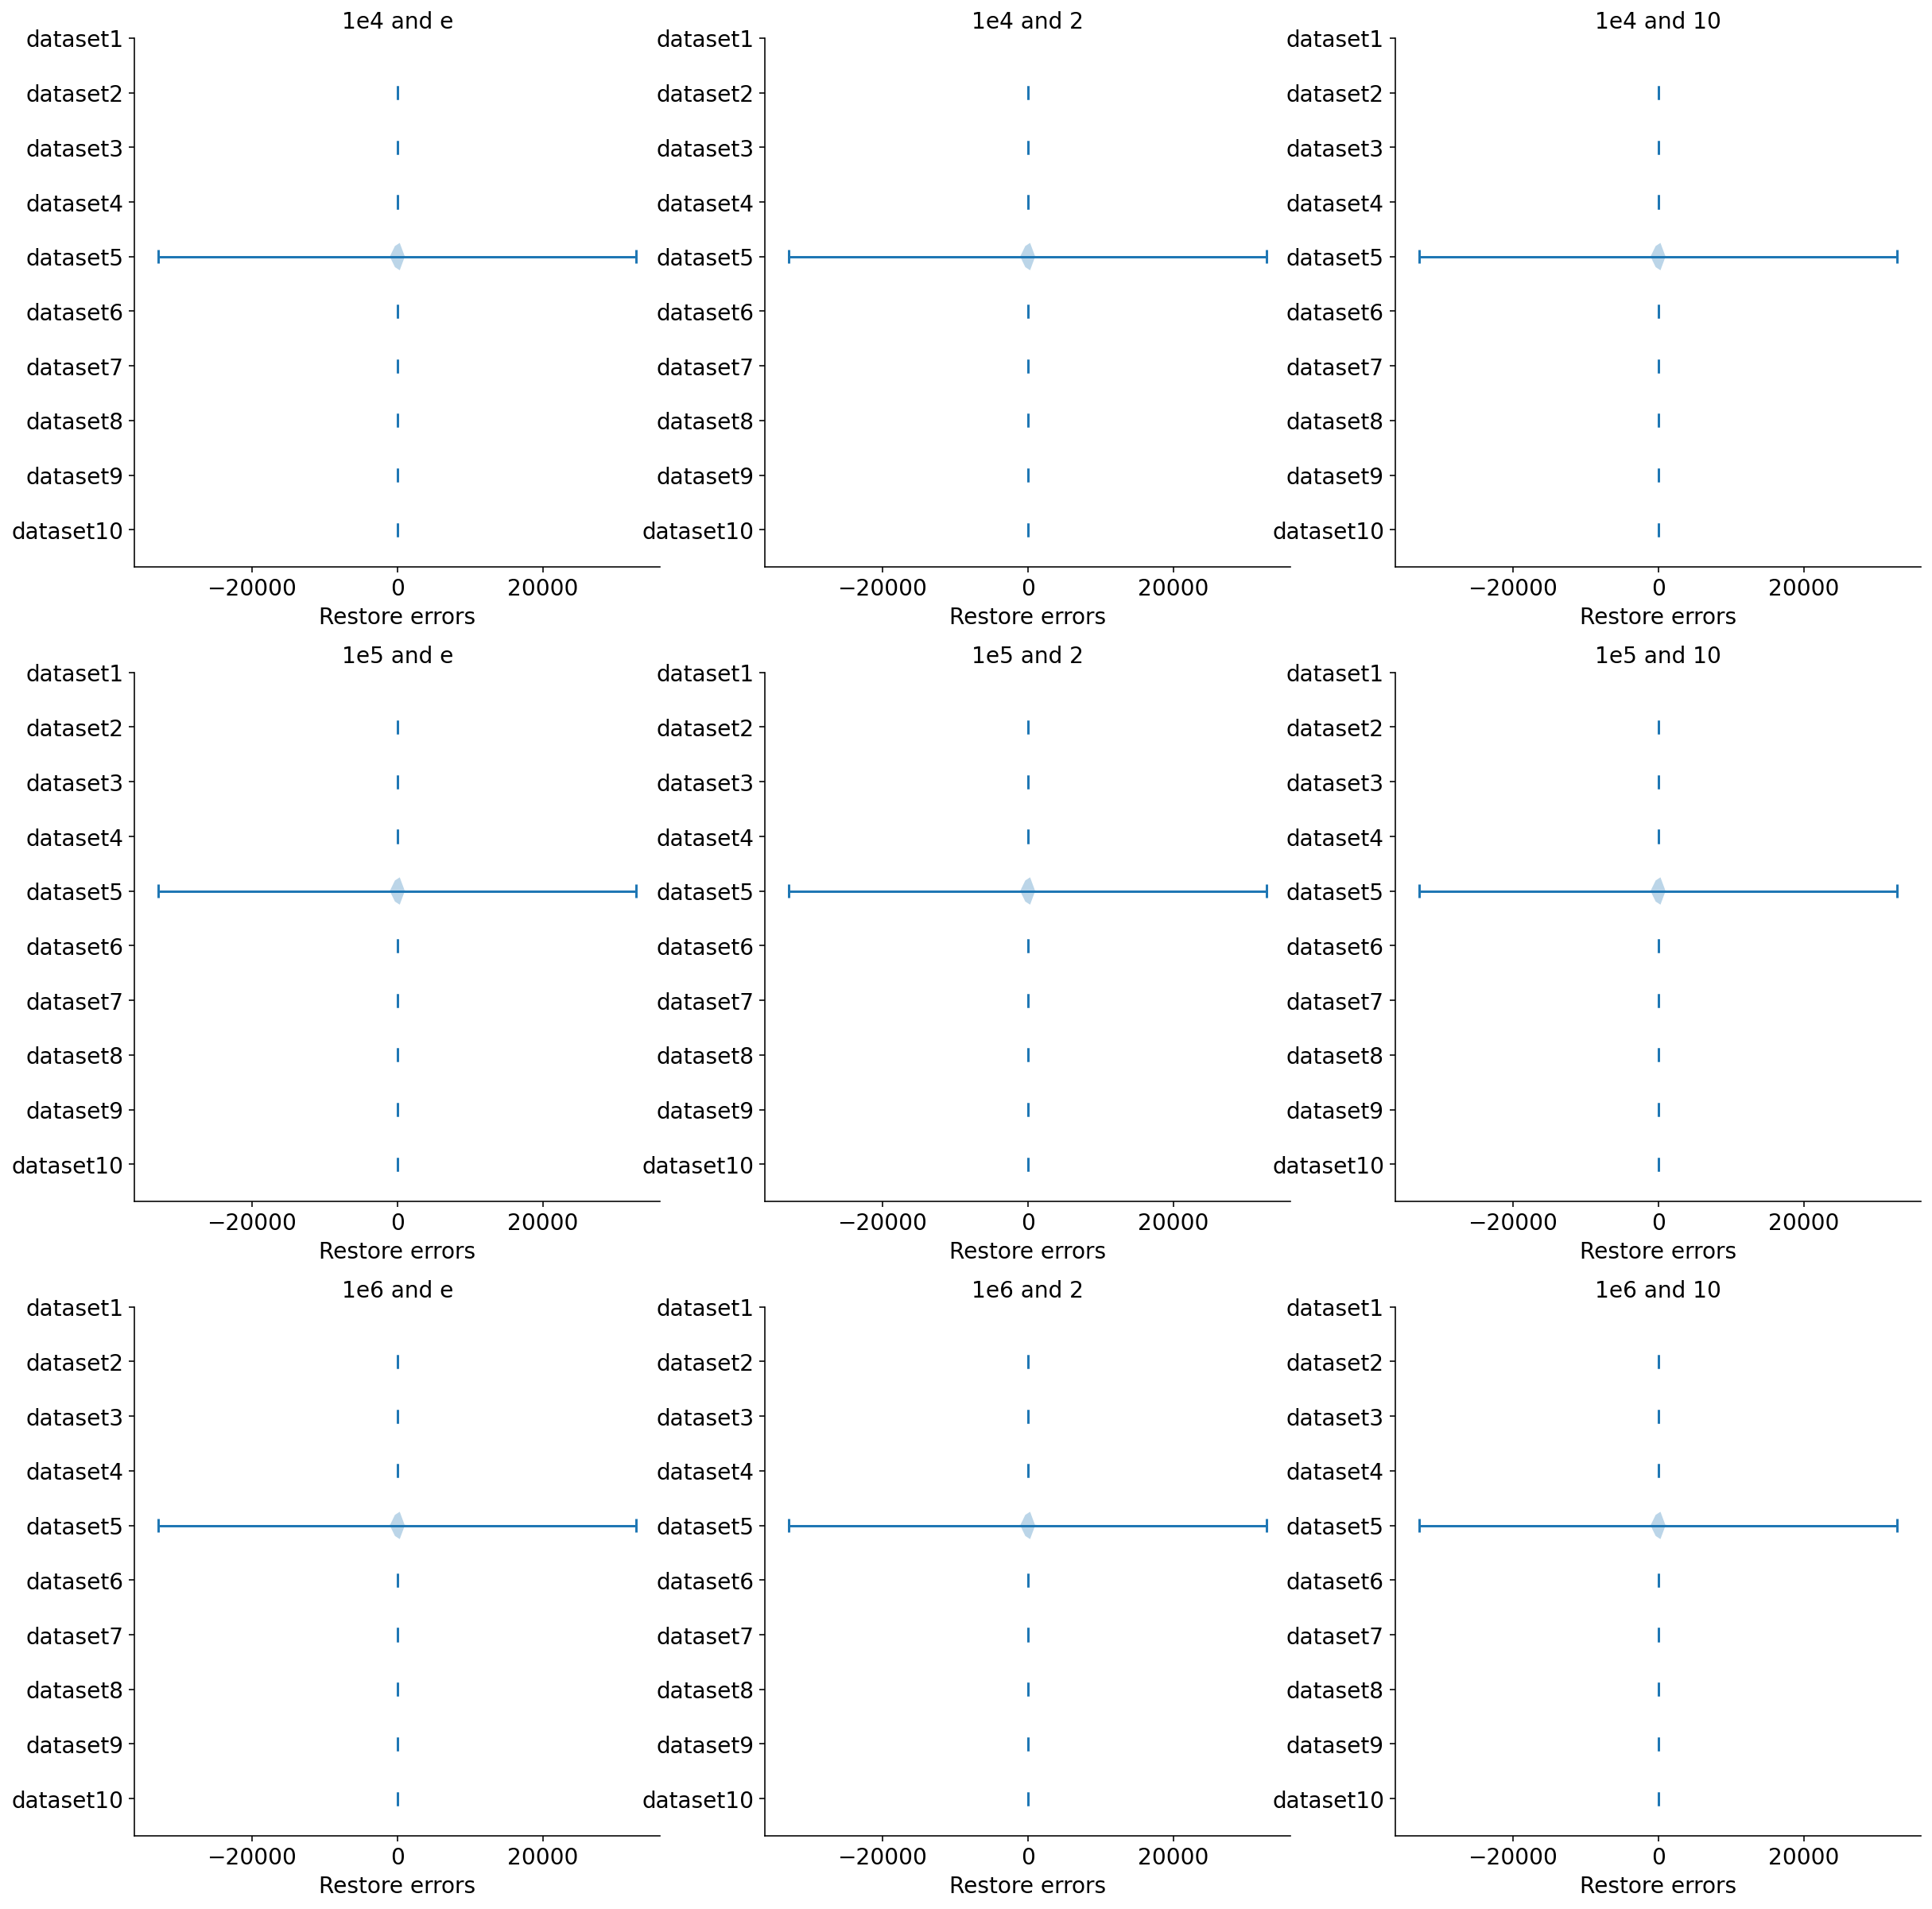

In [21]:
fig, axs = plt.subplots(3,3,figsize=(20,20))
axs = axs.ravel()
for i,ress in enumerate(rs):
    ax=axs[i]
    ax.violinplot(ress.values(),vert=False)
    ax.set_yticks([i+1 for i in range(10)])
    ax.set_yticklabels(['dataset'+str(10-i) for i in range(10)])
    ax.set_xlabel("Restore errors")
    ax.title.set_text(titles[i])
#plt.savefig('figures/Sup_figure_3.pdf',dpi=600,format='pdf', transparent=True)
plt.show()

In [ ]:
adata=sc.read('data/pbmc3k_qc_anno.h5ad')

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count', 'norm'
    obsp: 'connectivities', 'distances'

In [ ]:
adata.X.data

array([1., 1., 2., ..., 1., 1., 3.], dtype=float32)

## 1.Total count, Different base and pseudo count (1X2, 1X3, 2X3)

In [8]:
with open(f'data/results/bench_diff_cond.pickle', 'rb') as handle:
    ads=pickle.load(handle)

In [9]:
cond=[
[1e3,np.e,1],
[1e4,np.e,1],
[1e5,np.e,1],
[1e6,np.e,1],
[1e4,2,1],
[1e4,10,1],
[1e4,np.e,0.01],
[1e4,np.e,0.1],
]

1000.0 2.718281828459045 1 [2.71828197 0.99999998] 6.901333846038101e-13


100%|██████████| 1000/1000 [00:00<00:00, 1777.11it/s]


10000.0 2.718281828459045 1 [2.71828209 0.99999968] 2.0195708267261302e-10


100%|██████████| 1000/1000 [00:00<00:00, 1779.78it/s]


100000.0 2.718281828459045 1 [2.7182818  1.00000101] 7.563760183870395e-08


100%|██████████| 1000/1000 [00:00<00:00, 1777.99it/s]


1000000.0 2.718281828459045 1 [2.71828512 0.99877844] 4.445110873217547e-05


100%|██████████| 1000/1000 [00:00<00:00, 1773.84it/s]


10000.0 2 1 [2.00000007 0.99999973] 3.740029812110396e-10


100%|██████████| 1000/1000 [00:00<00:00, 1769.68it/s]


10000.0 10 1 [10.00000466  0.99999926] 2.879366945085238e-10


100%|██████████| 1000/1000 [00:00<00:00, 1788.77it/s]


10000.0 2.718281828459045 0.01 [2.71828207 0.00999947] 1.322564117405348e-10


100%|██████████| 1000/1000 [00:00<00:00, 1784.40it/s]


10000.0 2.718281828459045 0.1 [2.71828174 0.09999992] 1.3946885256495125e-10


100%|██████████| 1000/1000 [00:00<00:00, 1769.41it/s]


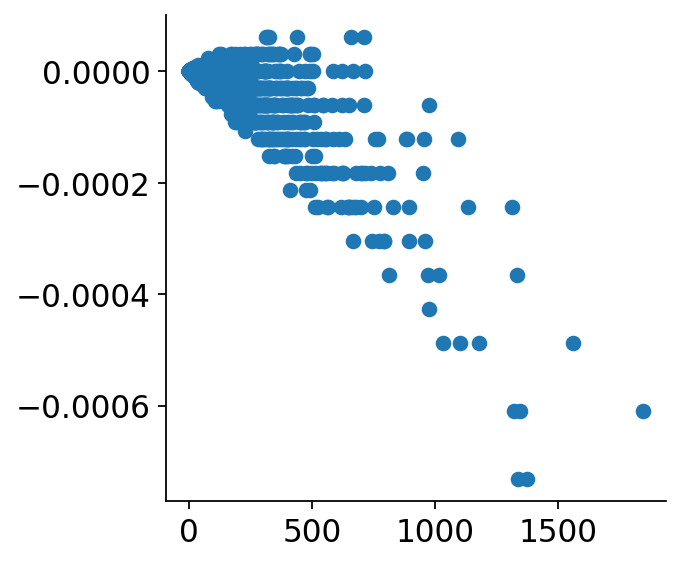

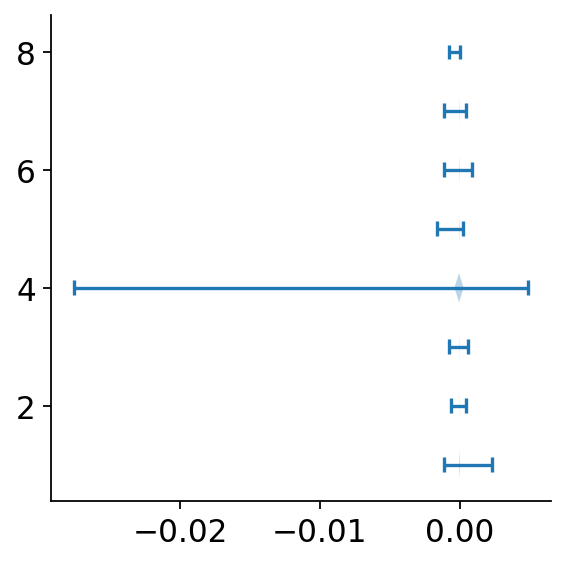

In [21]:
adata=ads[0]
rs,new_ads=[],[]
for ts,b,c in cond:
    ad=adata.copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(2, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
    rs.append(res)
    new_ads.append(new_ad.copy())
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()
plt.violinplot(rs,vert=False)
plt.show()

In [48]:
def f1(p, x, y):
    u = np.log(p[0]*x+p[2])/np.log(p[1])
    return np.sum((u-y)**2)

def grad_f1(p, x, y):
    u = np.log(p[0]*x+p[2])/np.log(p[1])
    dudx = p[0]/((p[0]*x+p[2])*np.log(p[1]))
    dudp = 1/np.log(p[1])
    grad_u = np.vstack((dudx, np.zeros_like(p[1:]), dudp))
    return 2*np.sum(grad_u*(u-y), axis=1)
bounds = [(1e-6, None), (1.9, None), (1e-6, None)]
#res = minimize(f1, [1, 2.7, 0.1], method='L-BFGS-B', tol=1e-6, bounds=bounds, args=(x, y))

In [49]:
smtx2=ad.X

In [66]:
N=20
ress=[]
for c_idx in range(10):
    N=10
    try:
        c = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(c.value_counts().sort_index().head(N).index)
        x = np.arange(1, N+1)
        res = minimize(f1, [10,20,1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
        ress.append([res.x[0],res.x[1],res.x[2],res.fun,N,int(res.fun<10**-5)])
    except:
        print(c_idx)
ress=pd.DataFrame(ress,columns=['s','b','c','l','n','p'])

In [67]:
ress

s          b         c             l   n  p
0  0.028549  23.950855  0.995116  2.356035e-06  10  1
1  0.020014  23.965184  0.997444  6.608673e-07  10  1
2  0.011938  23.980303  0.999031  9.739976e-08  10  1
3  0.018193  23.968537  0.997858  4.665752e-07  10  1
4  0.018952  23.967136  0.997690  5.418485e-07  10  1
5  0.014352  23.975731  0.998627  1.941756e-07  10  1
6  0.014338  23.975753  0.998629  1.935080e-07  10  1
7  0.020459  23.964362  0.997339  7.158217e-07  10  1
8  0.014771  23.974938  0.998550  2.161528e-07  10  1
9  0.012368  23.979489  0.998964  1.112458e-07  10  1

In [55]:
res

      fun: 2.763260144983019e-10
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.69289613e-06,  1.51067941e-10, -8.38561921e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 14
     njev: 26
   status: 0
  success: True
        x: array([2.62682110e-03, 2.39852839e+01, 9.99948447e-01])

10000.0 2.718281828459045 1 [19.99999969  0.99975642] 0.008863350213994743


100%|██████████| 1000/1000 [00:00<00:00, 1841.32it/s]


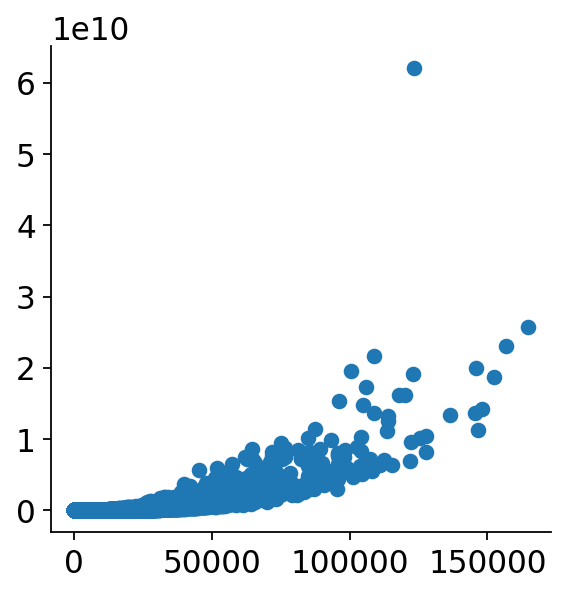

In [65]:
adata=ads[4]
rs,new_ads=[],[]
ts,b,c = cond[1]
ad=adata.copy()
ad.X=sparse.csc_matrix(ad.X)
ad.layers['count']=ad.X.copy()
sc.pp.normalize_total(ad, target_sum=ts)
ad.X.data=np.log(ad.X.data+c) / np.log(b)
#sc.pp.log1p(ad,base=b)
#auto solve
smtx2=ad.X
np.random.seed(0)
ys=[]
for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
    try:
        r = pd.Series(smtx2.getrow(c_idx).data)
        y = np.array(r.value_counts().sort_index().head(2).index)
        ys.append(y)
    except:
        print(c_idx)
ys=np.array(ys)
y1=ys[:,0]
y2=ys[:,1]
res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(2, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
print(ts,b,c,res.x,res.fun)
b,c=res.x
new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
new_ad.X=sparse.csc_matrix(new_ad.X)
if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
    res=new_ad.X.data-new_ad.layers['count'].data
else:
    raise('index not match')
rs.append(res)
new_ads.append(new_ad.copy())
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()

In [43]:
(np.e**ys[:,1]-1)/(np.e**ys[:,0]-1)

array([1.99999989, 1.99984418, 2.00015464, 1.99985916, 2.00012735,
       1.99999986, 2.0000004 , 2.00000009, 2.00000008, 2.00015261,
       1.99999979, 1.99989904, 2.00025198, 2.00000017, 1.99975311,
       1.99986191, 1.99999997, 2.0001136 , 2.00000004, 1.99999996,
       1.99986589, 2.00015138, 2.00000018, 2.00013482, 2.0001088 ,
       1.99980077, 1.999747  , 2.00000027, 2.00000007, 1.99999997,
       2.00000033, 2.00009694, 2.00023778, 1.99985963, 2.00025953,
       1.99999995, 1.99999988, 1.99990559, 1.99999957, 1.99980406,
       2.00018437, 1.9999999 , 2.00022531, 2.00014229, 1.99999987,
       2.00000044, 1.99981914, 2.00000007, 1.99999997, 2.00000013,
       1.99999991, 2.00000008, 1.99981113, 2.00000031, 1.99999999,
       1.99974132, 2.00014304, 2.00000004, 2.00013572, 1.9999997 ,
       2.00034438, 2.00021845, 2.        , 1.9998944 , 2.00000016,
       2.00010182, 1.99999997, 2.00022418, 1.99984067, 1.99999994,
       2.00019385, 1.99989843, 1.99999982, 1.99981983, 1.99981

In [44]:
(10**ys[:,1]-1)/(10**ys[:,0]-1)

array([2.00126003, 2.00084027, 2.00115957, 2.00096032, 2.00134645,
       2.00080218, 2.00079651, 2.00055451, 2.0010217 , 2.00116826,
       2.00118234, 2.00143576, 2.00086842, 2.0006603 , 2.0003815 ,
       2.00098495, 2.00097364, 2.00148104, 2.00066204, 2.00051589,
       2.00102058, 2.00117976, 2.00113726, 2.00128703, 2.00153861,
       2.00058082, 2.00036096, 2.0011611 , 2.00055279, 2.00076643,
       2.00061561, 2.00169634, 2.00089117, 2.00096653, 2.00085749,
       2.00081686, 2.0006864 , 2.00154843, 2.00128345, 2.00059621,
       2.0010279 , 2.0018127 , 2.00091548, 2.0012346 , 2.00089127,
       2.00074082, 2.00067772, 2.00121149, 2.00099055, 2.00052273,
       2.00154446, 2.0011845 , 2.00063231, 2.00110185, 2.00069303,
       2.00034177, 2.00122883, 2.001105  , 2.00128064, 2.00155077,
       2.00079534, 2.00093035, 2.00070282, 2.00136394, 2.00064881,
       2.0016238 , 2.0008445 , 2.00091668, 2.00081441, 2.00055809,
       2.00099469, 2.0014308 , 2.00077172, 2.00068244, 2.00066

In [36]:
ys

array([[0.00096727, 0.00193361],
       [0.00076479, 0.00152888],
       [0.00077123, 0.00154197],
       [0.00084543, 0.00169003],
       [0.00093559, 0.00187043],
       [0.00061588, 0.00123139],
       [0.00061112, 0.00122186],
       [0.00042561, 0.00085103],
       [0.00078421, 0.0015678 ],
       [0.00077944, 0.0015584 ],
       [0.00090772, 0.00181463],
       [0.00117971, 0.00235792],
       [0.00047303, 0.00094596],
       [0.00050675, 0.00101324],
       [0.00048256, 0.00096477],
       [0.00086223, 0.00172359],
       [0.0007474 , 0.00149424],
       [0.00104944, 0.00209791],
       [0.00050818, 0.0010161 ],
       [0.00039605, 0.00079195],
       [0.00088652, 0.00177214],
       [0.00078921, 0.00157792],
       [0.00087283, 0.00174489],
       [0.00088426, 0.00176786],
       [0.00109732, 0.00219355],
       [0.00059897, 0.00119746],
       [0.00047148, 0.00094262],
       [0.00089105, 0.00178131],
       [0.0004243 , 0.00084841],
       [0.00058836, 0.00117638],
       [0.

1000.0 2.718281828459045 1 [2.71828183 1.        ] 1.4493465099669396e-12


100%|██████████| 1000/1000 [00:00<00:00, 1817.59it/s]


10000.0 2.718281828459045 1 [2.71828183 1.00000001] 1.3972237391804432e-12


100%|██████████| 1000/1000 [00:00<00:00, 1837.12it/s]


100000.0 2.718281828459045 1 [2.71828183 0.99999999] 1.2144369896835249e-12


100%|██████████| 1000/1000 [00:00<00:00, 1821.03it/s]


1000000.0 2.718281828459045 1 [2.71828183 1.        ] 2.5226385596018893e-12


100%|██████████| 1000/1000 [00:00<00:00, 1830.99it/s]


10000.0 2 1 [2.         1.00000001] 1.3965457845355605e-12


100%|██████████| 1000/1000 [00:00<00:00, 1822.94it/s]


10000.0 10 1 [2.71828183 1.00001321] 1.5240713999331306e-08


100%|██████████| 1000/1000 [00:00<00:00, 1830.58it/s]


10000.0 2.718281828459045 0.01 [2.71850903 0.00999589] 3.669420960113334e-12


100%|██████████| 1000/1000 [00:00<00:00, 1807.58it/s]


10000.0 2.718281828459045 0.1 [2.71918066 0.09992373] 2.3543885576398704e-12


100%|██████████| 1000/1000 [00:00<00:00, 1820.00it/s]


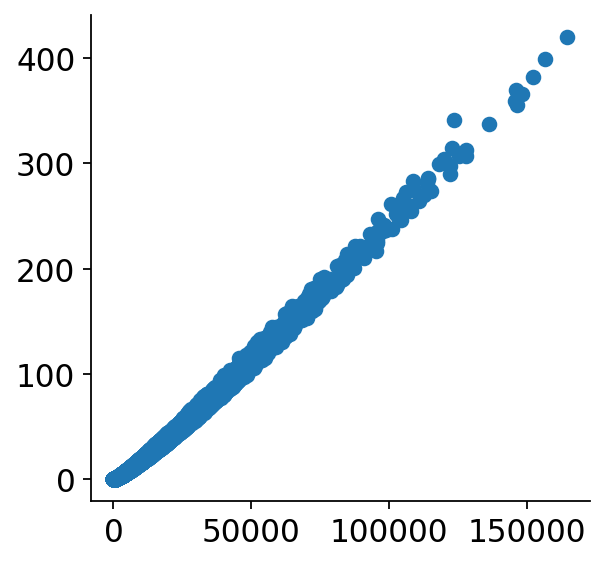

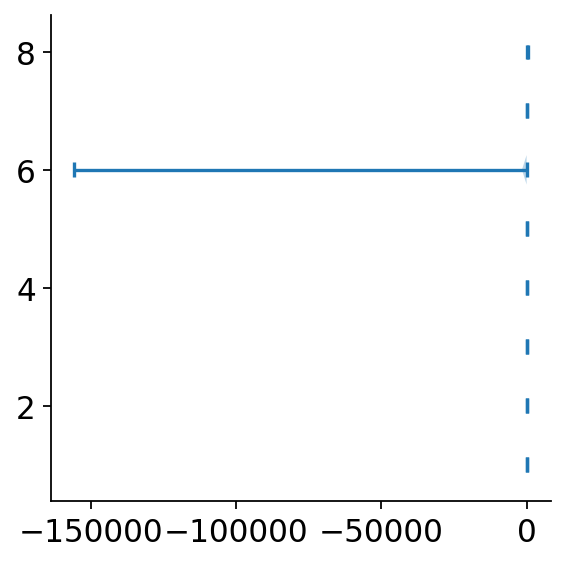

In [34]:
rss=[]
for adata in ads[4:5]:
    rs,new_ads=[],[]
    for ts,b,c in cond:
        ad=adata.copy()
        ad.X=sparse.csc_matrix(ad.X)
        ad.layers['count']=ad.X.copy()
        sc.pp.normalize_total(ad, target_sum=ts)
        ad.X.data=np.log(ad.X.data+c) / np.log(b)
        #sc.pp.log1p(ad,base=b)
        #auto solve
        smtx2=ad.X
        np.random.seed(1)
        ys=[]
        for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],200),replace=False):
            try:
                r = pd.Series(smtx2.getrow(c_idx).data)
                y = np.array(r.value_counts().sort_index().head(2).index)
                ys.append(y)
            except:
                print(c_idx)
        ys=np.array(ys)
        y1=ys[:,0]
        y2=ys[:,1]
        res = minimize(solve_bc, [np.e,1], method='L-BFGS-B', tol=1e-15,bounds=[(2, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
        print(ts,b,c,res.x,res.fun)
        b,c=res.x
        new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
        new_ad.X=sparse.csc_matrix(new_ad.X)
        if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
            res=new_ad.X.data-new_ad.layers['count'].data
        else:
            raise('index not match')
        rs.append(res)
        new_ads.append(new_ad.copy())
    plt.plot(new_ad.layers['count'].data,res,'o')
    plt.show()
    plt.violinplot(rs,vert=False)
    plt.show()
    rss.append(rs)

In [24]:
ads[4].X.data

array([250., 820., 651., ...,  80., 234., 429.], dtype=float32)

In [25]:
ads[5].X.data

array([ 3., 15.,  1., ..., 12., 72., 96.], dtype=float32)

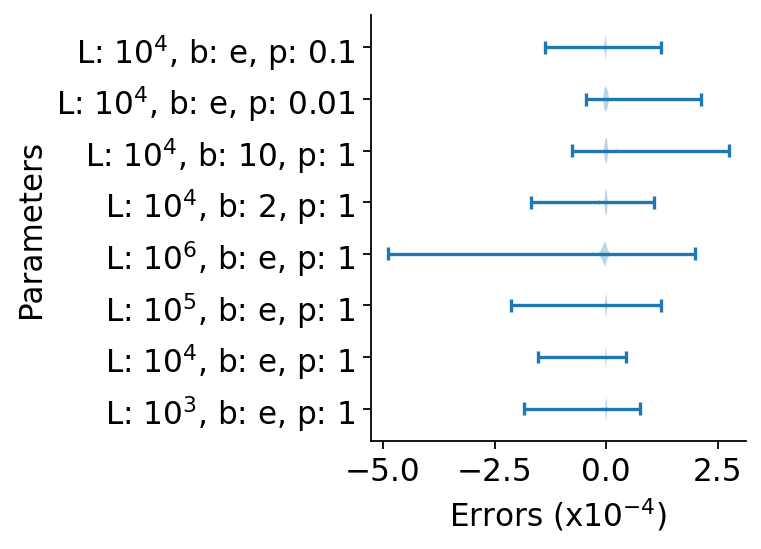

In [ ]:
figsize(3,3.5)
plt.violinplot([i*10000 for i in rs],vert=False)
plt.grid(visible=False)
plt.xlabel(r'Errors (x$10^{-4}$)')
plt.ylabel('Parameters')
y_ticks = range(1, len(rs) + 1)  # Generate y-tick positions
y_labels = [r'L: $10^{3}$, b: e, p: 1', r'L: $10^{4}$, b: e, p: 1', r'L: $10^{5}$, b: e, p: 1', r'L: $10^{6}$, b: e, p: 1',
            r'L: $10^{4}$, b: 2, p: 1', r'L: $10^{4}$, b: 10, p: 1', r'L: $10^{4}$, b: e, p: 0.01', r'L: $10^{4}$, b: e, p: 0.1']  # Generate y-tick labels
plt.yticks(y_ticks, y_labels)
plt.savefig('figures/PBMC/method_errors.pdf',dpi=300, bbox_inches='tight',transparent=True)

## floating + known base

100%|██████████| 2638/2638 [00:16<00:00, 160.33it/s]


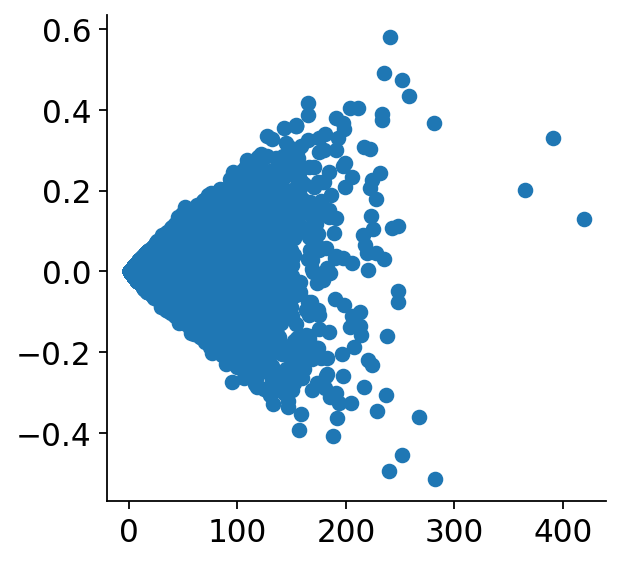

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

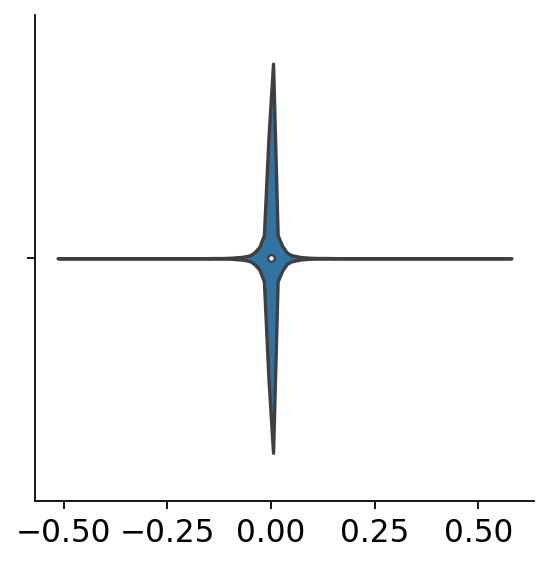

In [ ]:
for ts,b,c in [[1e4,np.e,1]]:
    ad=adata.copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    ad.X.data=ad.X.data.astype(np.float16).astype(np.float32)
    
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
        
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()
sns.violinplot(res)

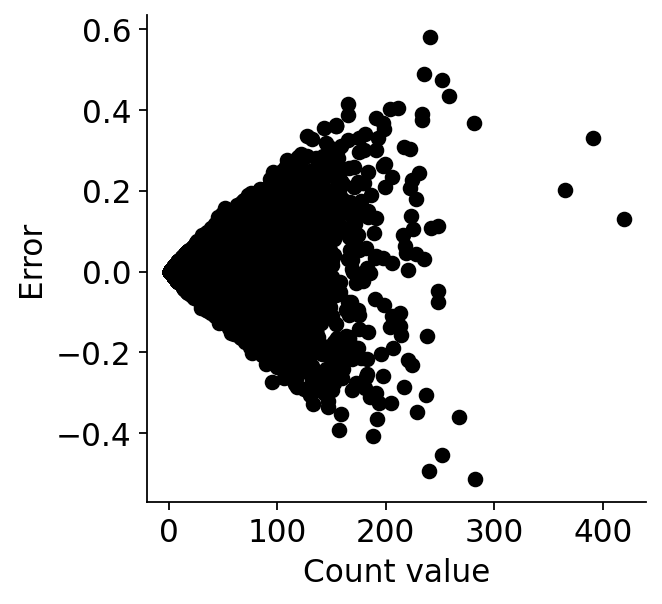

In [ ]:
figsize(4,4)
plt.plot(new_ad.layers['count'].data,res,'o',c='black')
plt.grid(visible=False)
plt.xlabel('Count values')
plt.ylabel('Errors')
plt.savefig('figures/PBMC/rounding_errors_floating_kb.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
fk_res,fk_ad=res,new_ad

In [ ]:
(fk_res>0.5).sum()

1

In [ ]:
ad=fk_ad.copy()

[<matplotlib.lines.Line2D>]

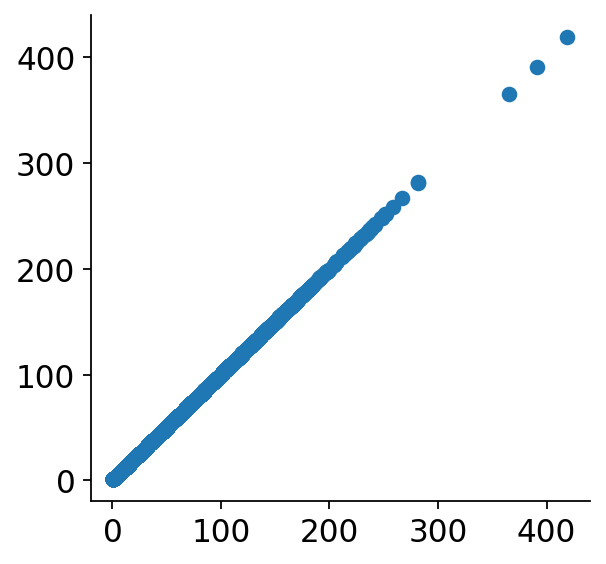

In [ ]:
plt.plot(ad.X.data,ad.layers['count'].data,'o')

## floating + auto base

10000.0 2.718281828459045 1 [2.72019642 0.99665196] 0.007728852064651502


100%|██████████| 2638/2638 [00:15<00:00, 171.41it/s]


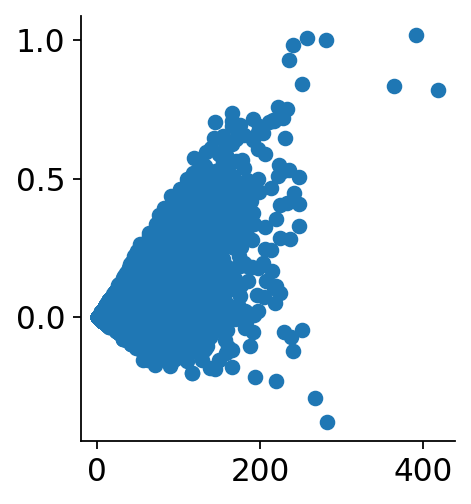

{'bodies': [<matplotlib.collections.PolyCollection>],
 'cmaxes': <matplotlib.collections.LineCollection>,
 'cmins': <matplotlib.collections.LineCollection>,
 'cbars': <matplotlib.collections.LineCollection>}

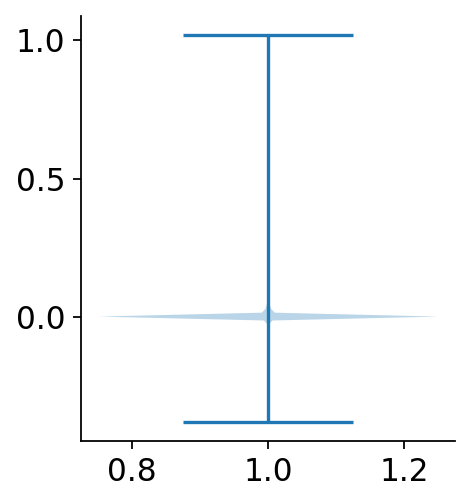

In [ ]:
for ts,b,c in [[1e4,np.e,1]]:
    ad=adata.copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    ad.X.data=ad.X.data.astype(np.float16).astype(np.float32)
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
        
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()
plt.violinplot(res,vert=True)

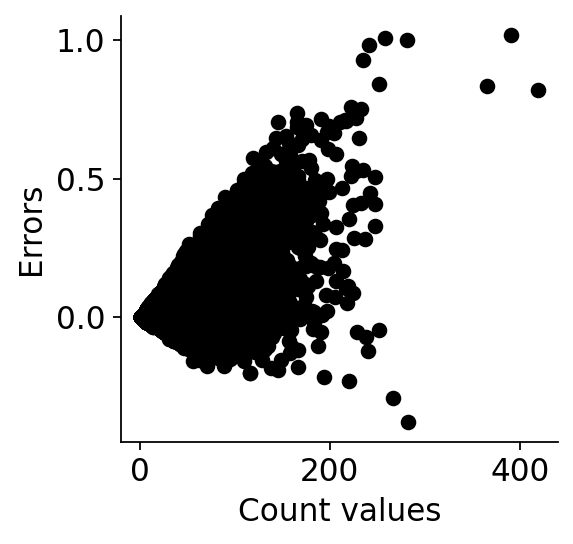

In [ ]:
figsize(3.5,3.5)
plt.plot(new_ad.layers['count'].data,res,'o',c='black')
plt.grid(visible=False)
plt.xlabel('Count values')
plt.ylabel('Errors')
plt.savefig('figures/PBMC/rounding_errors_floating_ad.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
fa_res,fa_ad=res,new_ad.copy()

[<matplotlib.lines.Line2D>]

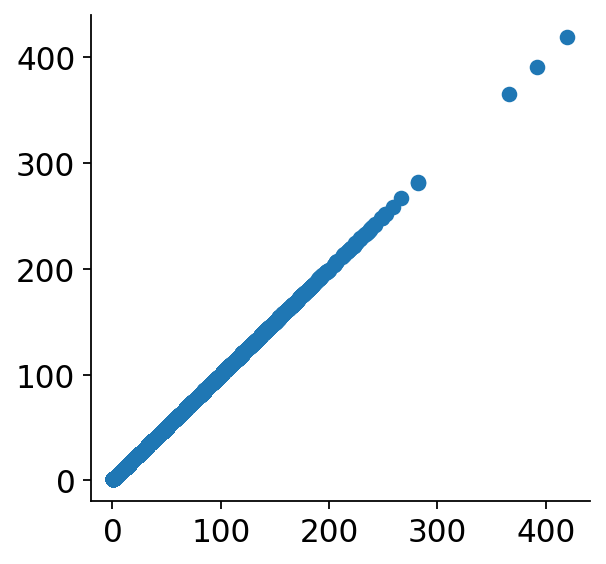

In [ ]:
ad=fa_ad.copy()
plt.plot(ad.X.data,ad.layers['count'].data,'o')

In [ ]:
fa_ad.X

<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Column format>

In [ ]:
(fa_res>0.5).sum()

69

## HVG + auto base

10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:05<00:00, 518.78it/s]


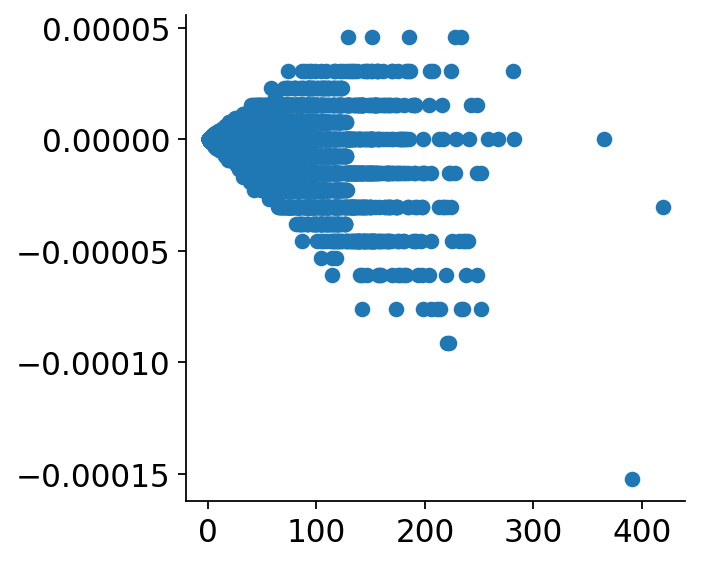

{'bodies': [<matplotlib.collections.PolyCollection>],
 'cmaxes': <matplotlib.collections.LineCollection>,
 'cmins': <matplotlib.collections.LineCollection>,
 'cbars': <matplotlib.collections.LineCollection>}

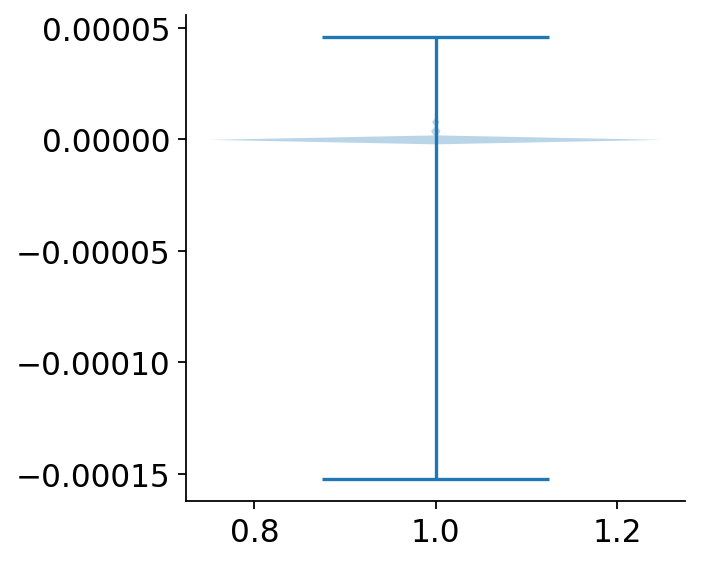

In [ ]:
for ts,b,c in [[1e4,np.e,1]]:
    ad=adata.copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    sc.pp.highly_variable_genes(ad,layer='count', n_top_genes=2000,flavor='seurat_v3')
    ad = ad[:, ad.var.highly_variable]
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
        
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()
plt.violinplot(res,vert=True)

In [ ]:
hvg_res,hvg_ad=res,new_ad

In [ ]:
(hvg_res>0.5).sum()

0

[<matplotlib.lines.Line2D>]

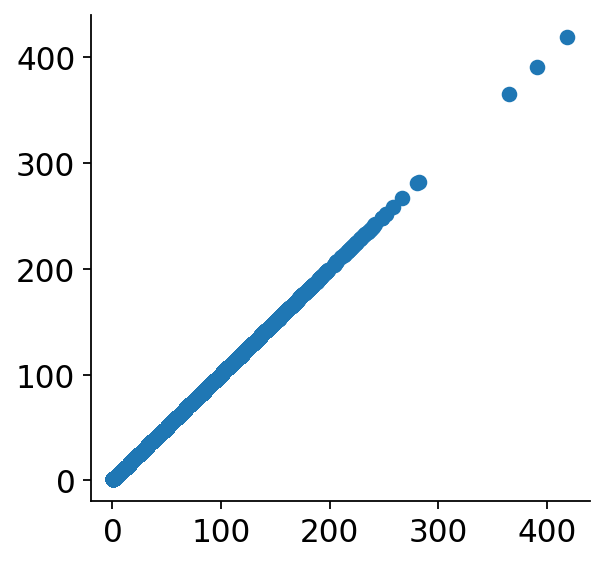

In [ ]:
ad=hvg_ad.copy()
plt.plot(ad.X.data,ad.layers['count'].data,'o')

### save

In [ ]:
with open(f'data/pbmc3k_qc_anno_results.pickle', 'wb') as handle:
    pickle.dump([[rs,new_ads],[fk_res,fk_ad],[fa_res,fa_ad],[hvg_res,hvg_ad]], handle, protocol=pickle.HIGHEST_PROTOCOL)

## UMAP

In [ ]:
ad=adata.copy()
ad.obs['group']='Origin'

In [ ]:
hvg_ad.obs['group']='HVG'
fa_ad.obs['group']='Floating'

In [ ]:
hvg_ad

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'group'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count', 'norm'
    obsp: 'connectivities', 'distances'

In [ ]:
ad=ad.concatenate([fa_ad,hvg_ad])

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
ad

AnnData object with n_obs × n_vars = 7914 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'group', 'batch'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'dispersions', 'dispersions_norm', 'highly_variable-0', 'means-0', 'highly_variable-1', 'means-1', 'highly_variable-2', 'means-2', 'highly_variable_rank-2', 'variances-2', 'variances_norm-2'
    obsm: 'X_pca', 'X_umap'
    layers: 'count', 'norm'

In [ ]:
sc.pp.normalize_total(ad, target_sum=1e4)
sc.pp.log1p(ad)

In [ ]:
sc.tl.pca(ad, svd_solver='arpack',use_highly_variable=False)
sc.pp.neighbors(ad,n_neighbors=10, n_pcs=40)
sc.tl.umap(ad)

In [ ]:
ad.obs['group']=ad.obs['group'].cat.reorder_categories(['Origin','Floating','HVG'])

In [ ]:
ad.uns['leiden_colors']=['#5C89CC', '#FFB6C1', '#D9C566', '#FF8011', '#9440F3', '#E30B5C', '#AFE1AF', '#74caff']

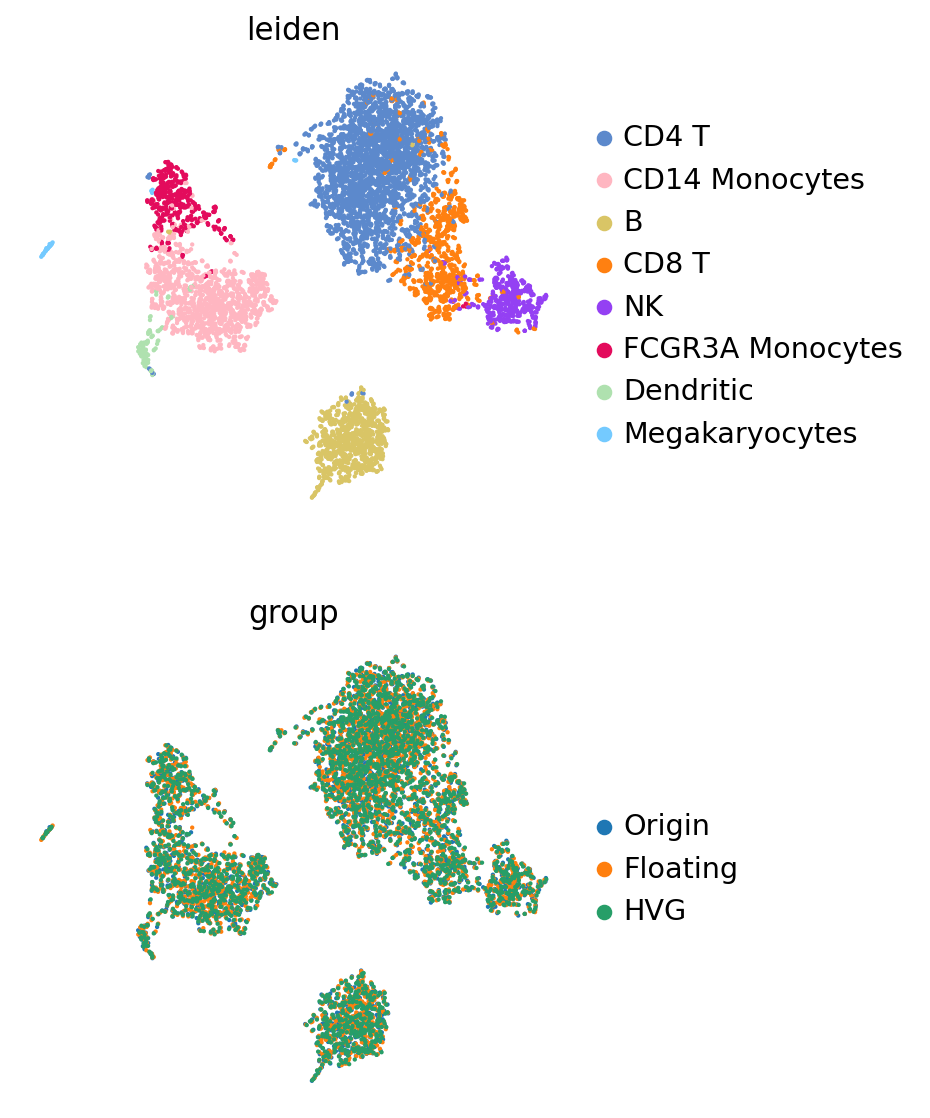

In [ ]:
figsize(4,4)
sc.pl.umap(ad, color=['leiden','group'],frameon=False,ncols=1,save='pbmc3k_benchmark0.pdf')

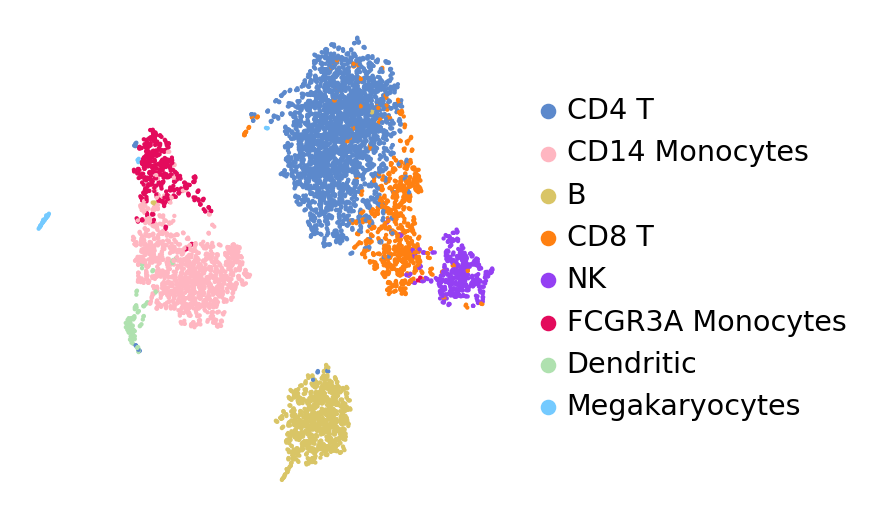

In [ ]:
figsize(4,4)
sc.pl.umap(ad, color=['leiden'],frameon=False,ncols=1,title='',save='pbmc3k_benchmark1.pdf')

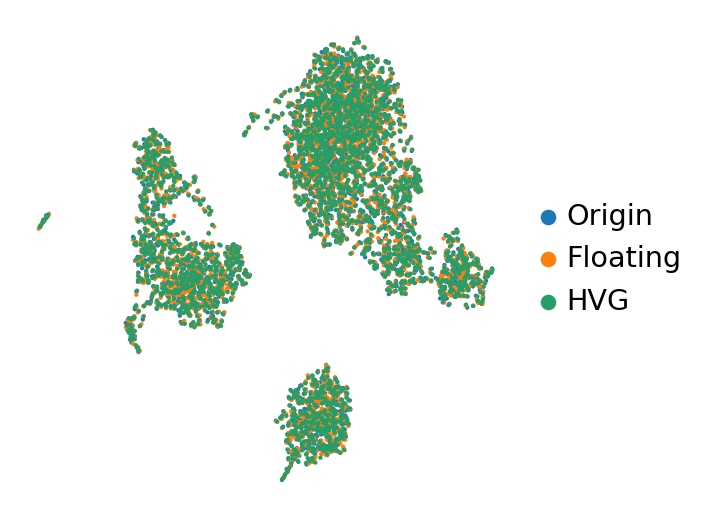

In [ ]:
figsize(4,4)
sc.pl.umap(ad, color=['group'],frameon=False,ncols=1,title='',save='pbmc3k_benchmark2.pdf')

In [ ]:
ad.write_h5ad('data/pbmc3k_benchmark.h5ad')

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


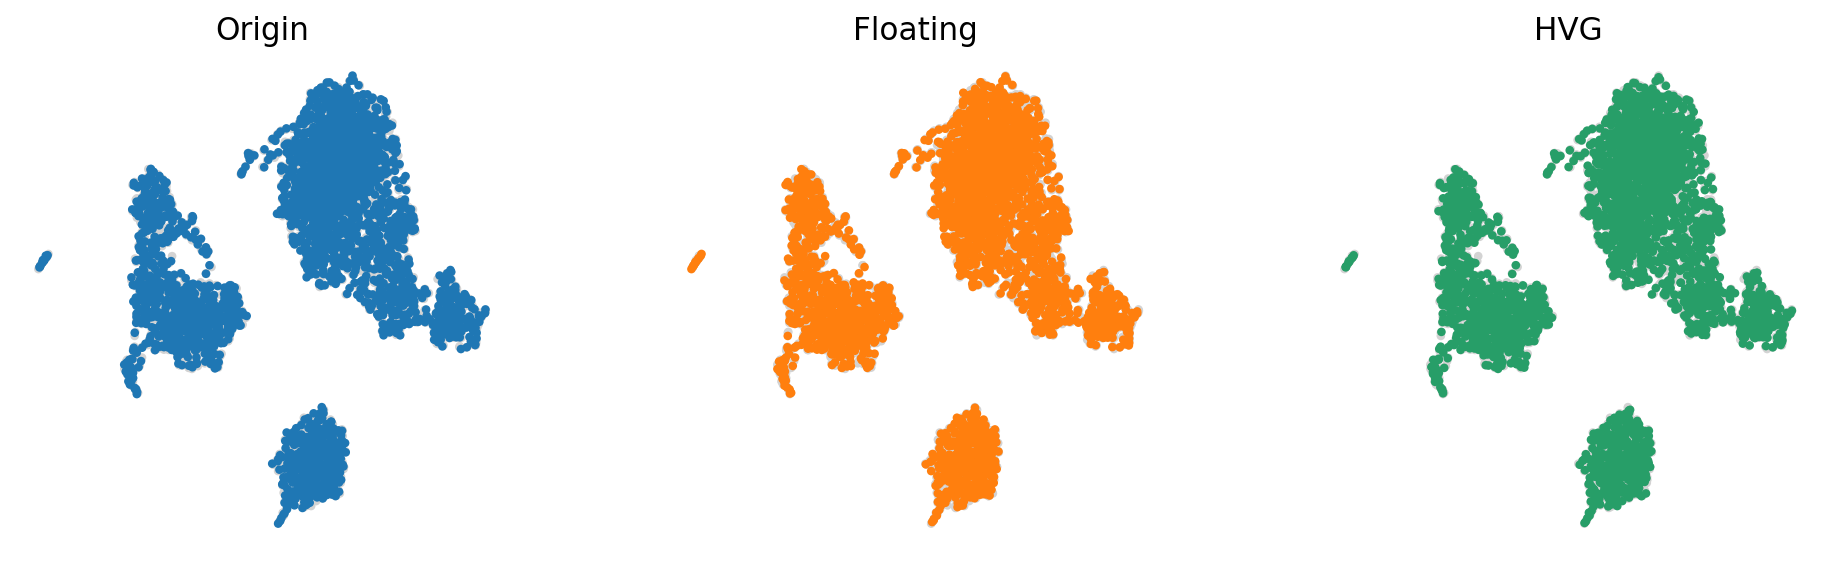

In [ ]:
cluster_small_multiples(ad,'group',save='pbmc3k_benchmark.pdf')

# rounds the elements of an array to the specified number of decimal places

In [ ]:
adata=sc.read('data/pbmc3k_qc_anno.h5ad')
adata.X=adata.layers['count'].copy()

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count', 'norm'
    obsp: 'connectivities', 'distances'

In [ ]:
ad.X.data

array([1.6021183, 1.8285189, 1.4419494, ..., 2.1129642, 1.0703647,
       2.3553658], dtype=float32)

10000.0 2.718281828459045 1 [2.73124568 0.98553681] 0.273348141595169


100%|██████████| 2638/2638 [00:15<00:00, 169.75it/s]


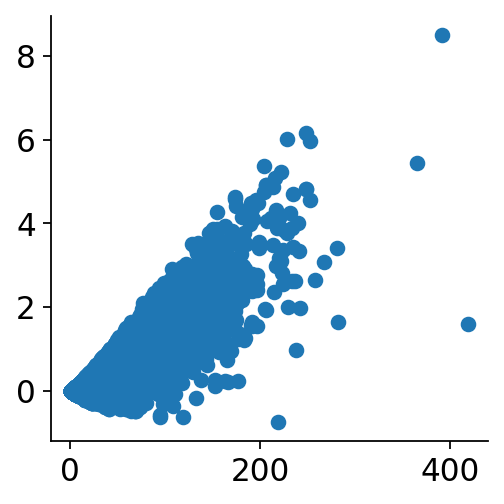

10000.0 2.718281828459045 1 [2.71858521 0.99949668] 0.0019235858450206299


100%|██████████| 2638/2638 [00:15<00:00, 171.35it/s]


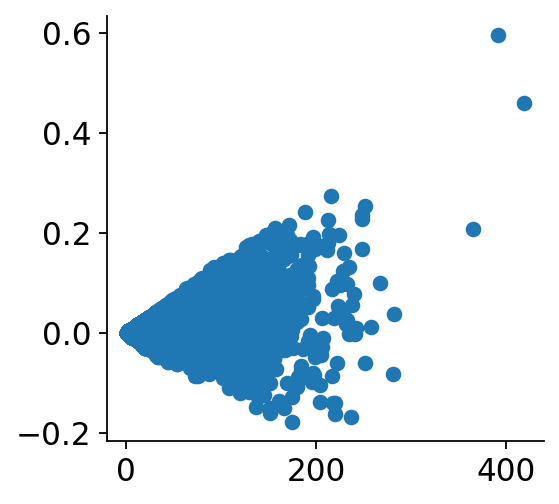

10000.0 2.718281828459045 1 [2.71814632 1.00029789] 2.5691641481452587e-05


100%|██████████| 2638/2638 [00:15<00:00, 171.12it/s]


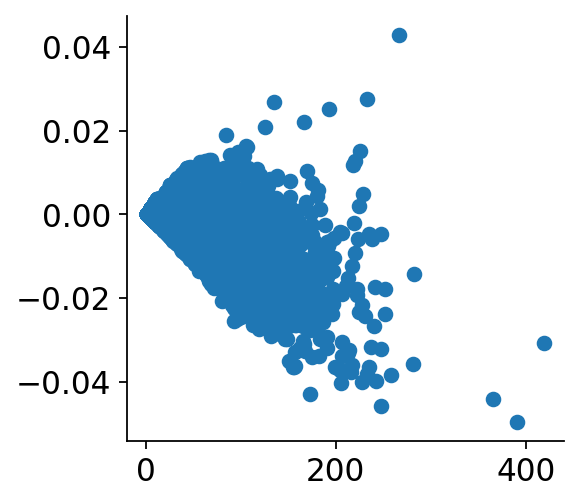

10000.0 2.718281828459045 1 [2.71827667 1.00000452] 2.335881042041391e-07


100%|██████████| 2638/2638 [00:15<00:00, 171.80it/s]


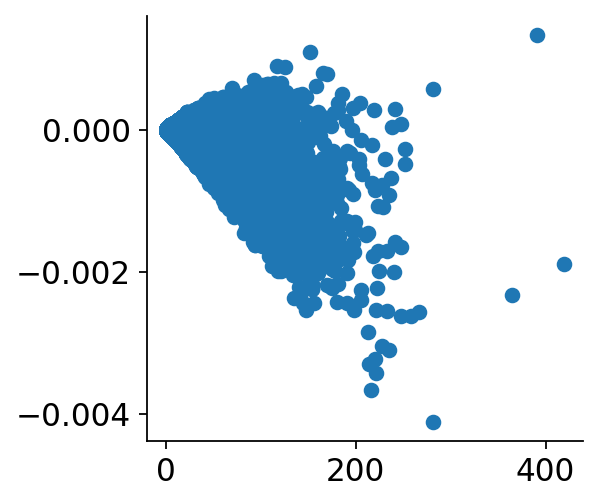

10000.0 2.718281828459045 1 [2.71827978 1.00000282] 2.1589863414209206e-09


100%|██████████| 2638/2638 [00:15<00:00, 171.34it/s]


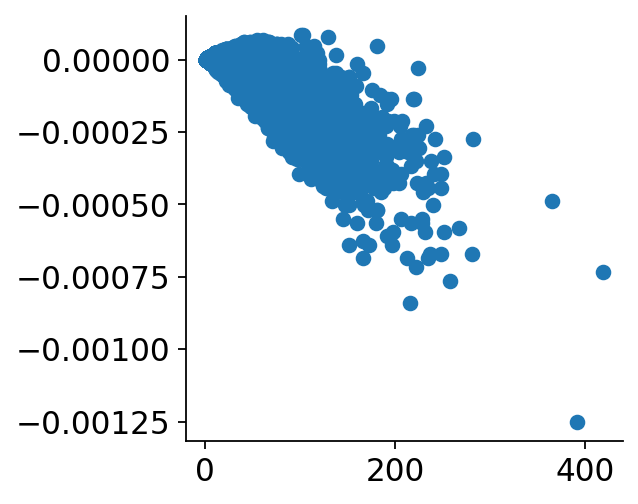

10000.0 2.718281828459045 1 [2.7182814  1.00000068] 1.7284746107388254e-10


100%|██████████| 2638/2638 [00:15<00:00, 168.87it/s]


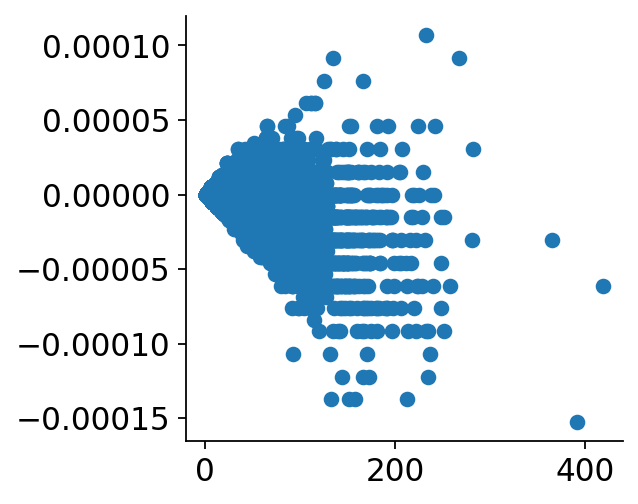

10000.0 2.718281828459045 1 [2.71828198 0.99999972] 2.870344342155565e-10


100%|██████████| 2638/2638 [00:15<00:00, 171.52it/s]


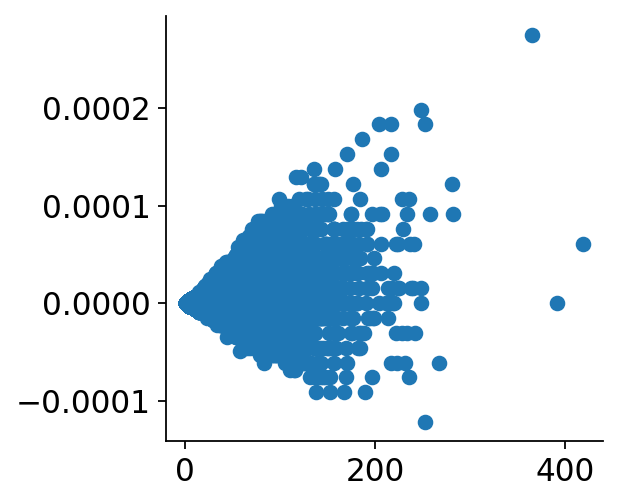

{'bodies': [<matplotlib.collections.PolyCollection>],
 'cmaxes': <matplotlib.collections.LineCollection>,
 'cmins': <matplotlib.collections.LineCollection>,
 'cbars': <matplotlib.collections.LineCollection>}

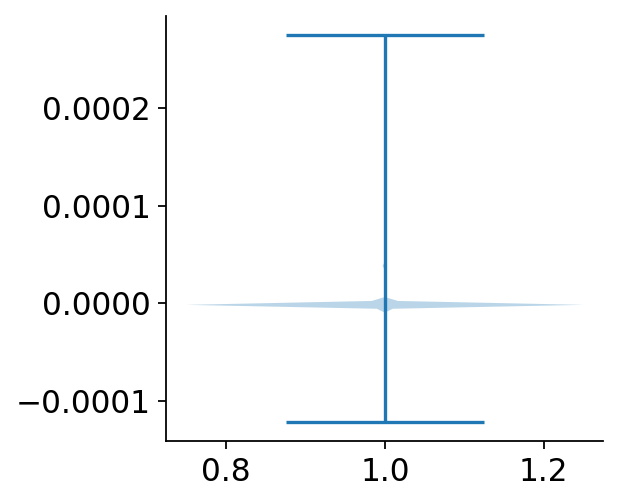

In [ ]:
dp_res,dp_ad,dp_para=[],[],[]
for k in range(2,9):
    ts,b,c=[1e4,np.e,1]
    ad=adata.copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    ad.X.data=np.around(ad.X.data, decimals=k).astype(np.float32)
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    dp_para.append([b,c,res.fun])
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
        plt.plot(new_ad.layers['count'].data,res,'o')
        plt.show()
    else:
        raise('index not match')
    dp_res.append(res)
    dp_ad.append(new_ad.copy())
plt.violinplot(res,vert=True)

In [ ]:
dp_res

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]

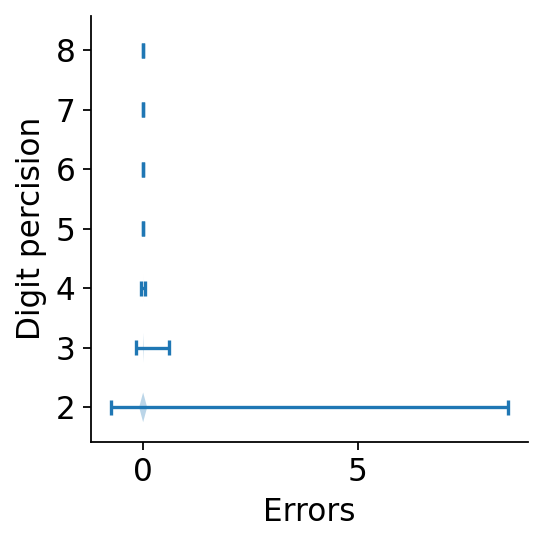

In [ ]:
figsize(3.5,3.5)
plt.violinplot(dp_res,vert=False)
plt.grid(visible=False)
plt.xlabel('Errors')
plt.ylabel('Digit percision')
y_ticks = range(1, len(dp_res) + 1)  # Generate y-tick positions
y_labels = [i+1 for i in y_ticks]  # Generate y-tick labels
plt.yticks(y_ticks, y_labels)
plt.savefig('figures/PBMC/digit_precision_errors.pdf',dpi=300, bbox_inches='tight',transparent=True)

Text(0, 0.5, 'Error')

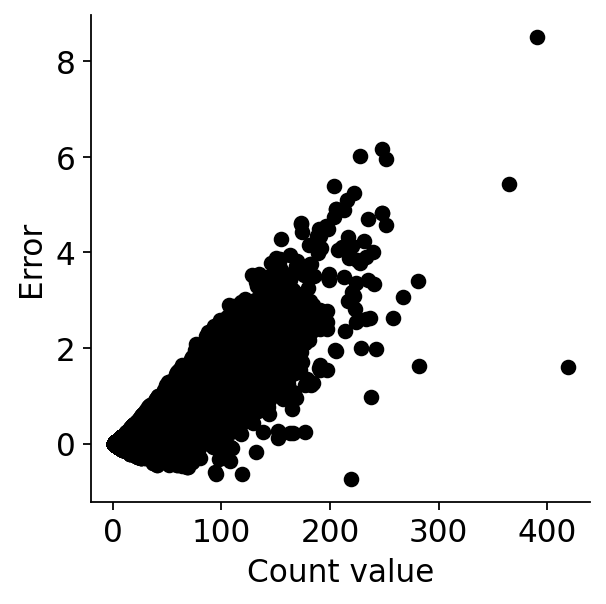

In [ ]:
figsize(4,4)
plt.plot(dp_ad[0].layers['count'].data,dp_res[0],'o',c='black')
plt.grid(visible=False)
plt.xlabel('Count value')
plt.ylabel('Error')
#plt.savefig('figures/PBMC/rounding_errors_floating_ad.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
dp_para

[[2.731245684555231, 0.9855368064078, 0.273348141595169],
 [2.718585212615867, 0.9994966790017392, 0.0019235858450206299],
 [2.7181463182923307, 1.0002978865773906, 2.5691641481452587e-05],
 [2.7182766747331377, 1.0000045171435494, 2.335881042041391e-07],
 [2.718279783852874, 1.0000028171345348, 2.1589863414209206e-09],
 [2.7182813994639896, 1.0000006794127998, 1.7284746107388254e-10],
 [2.718281984401084, 0.999999723656416, 2.870344342155565e-10]]

In [ ]:
dp_para=pd.DataFrame(dp_para,columns=['b','c','mse'])

In [ ]:
dp_para['dp']=range(2,9)
dp_para['dp']=dp_para['dp'].astype(str).astype('category')

In [ ]:
dp_para['dp']=dp_para['dp'].cat.reorder_categories(['2', '3', '4', '5', '6', '7', '8'][::-1])

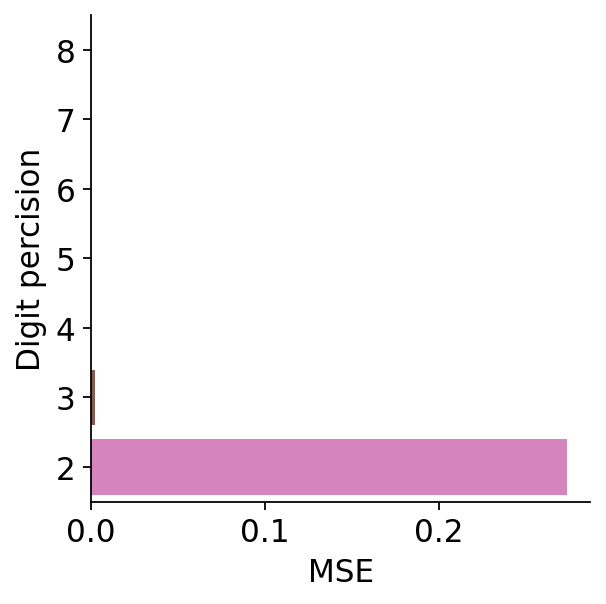

In [ ]:
figsize(4,4)
sns.barplot(y='dp',x='mse',data=dp_para)
plt.grid(visible=False)
plt.xlabel('MSE')
plt.ylabel('Digit percision')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figures/PBMC/DP_MSE.pdf',dpi=300, bbox_inches='tight',transparent=True)

## UMAP

In [ ]:
ad=adata.copy()

In [ ]:
ad=ad.concatenate(dp_ad[:2])

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
ad.obs.batch

index
AAACATACAACCAC-1-0    0
AAACATTGAGCTAC-1-0    0
AAACATTGATCAGC-1-0    0
AAACCGTGCTTCCG-1-0    0
AAACCGTGTATGCG-1-0    0
                     ..
TTTCGAACTCTCAT-1-2    2
TTTCTACTGAGGCA-1-2    2
TTTCTACTTCCTCG-1-2    2
TTTGCATGAGAGGC-1-2    2
TTTGCATGCCTCAC-1-2    2
Name: batch, Length: 7914, dtype: category
Categories (3, object): ['0', '1', '2']

In [ ]:
ad.X.data

array([1.     , 1.     , 2.     , ..., 1.     , 1.     , 3.00133],
      dtype=float32)

In [ ]:
sc.pp.normalize_total(ad, target_sum=1e4)
sc.pp.log1p(ad)

In [ ]:
sc.tl.pca(ad, svd_solver='arpack',use_highly_variable=False)
sc.pp.neighbors(ad)
sc.tl.umap(ad)

In [ ]:
ad.obs['batch']=ad.obs.batch.replace({'0': 'Origin', '1': '2-DP','2':'3-DP'})

In [ ]:
ad.uns['leiden_colors']=['#5C89CC', '#FFB6C1', '#D9C566', '#FF8011', '#9440F3', '#E30B5C', '#AFE1AF', '#74caff']

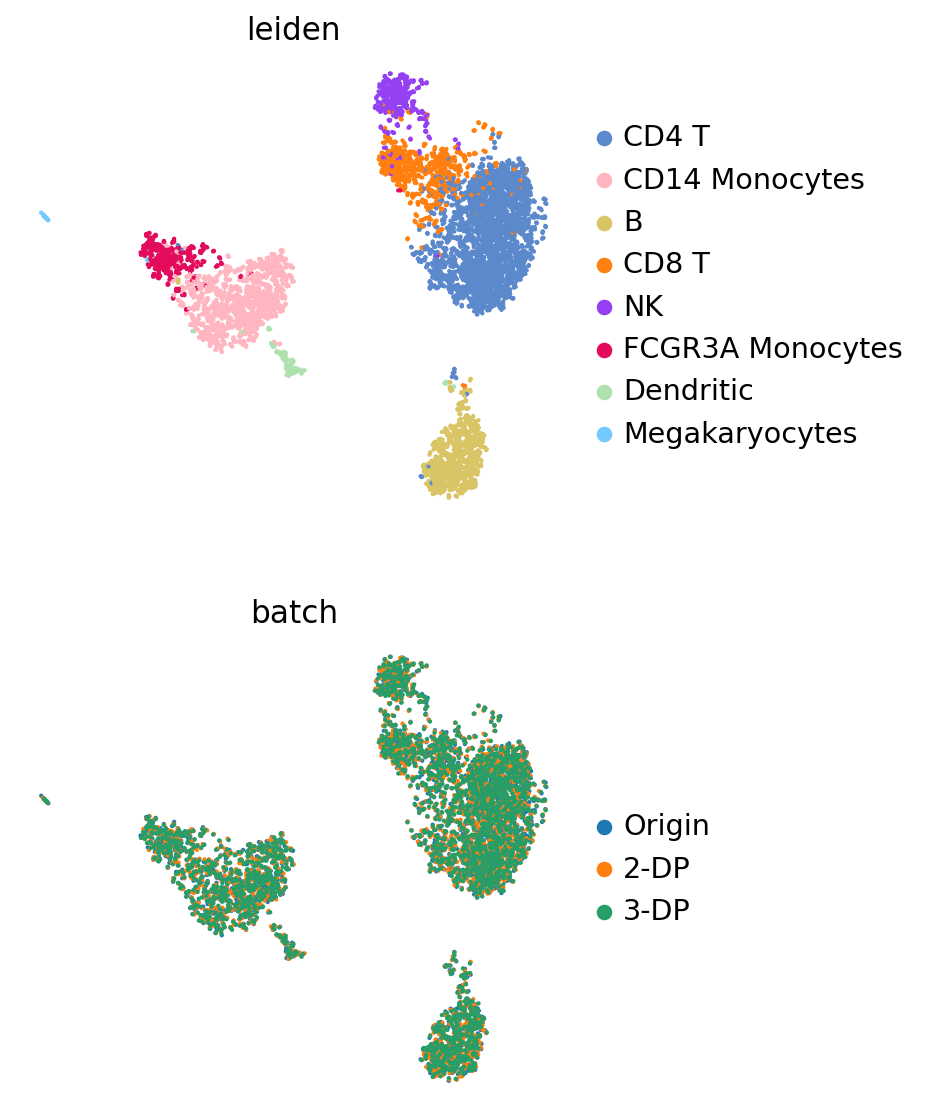

In [ ]:
figsize(4,4)
sc.pl.umap(ad, color=['leiden','batch'],frameon=False,ncols=1,save='pbmc3k_DP.pdf')

In [ ]:
ad.write_h5ad('data/pbmc3k_DP.h5ad')

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


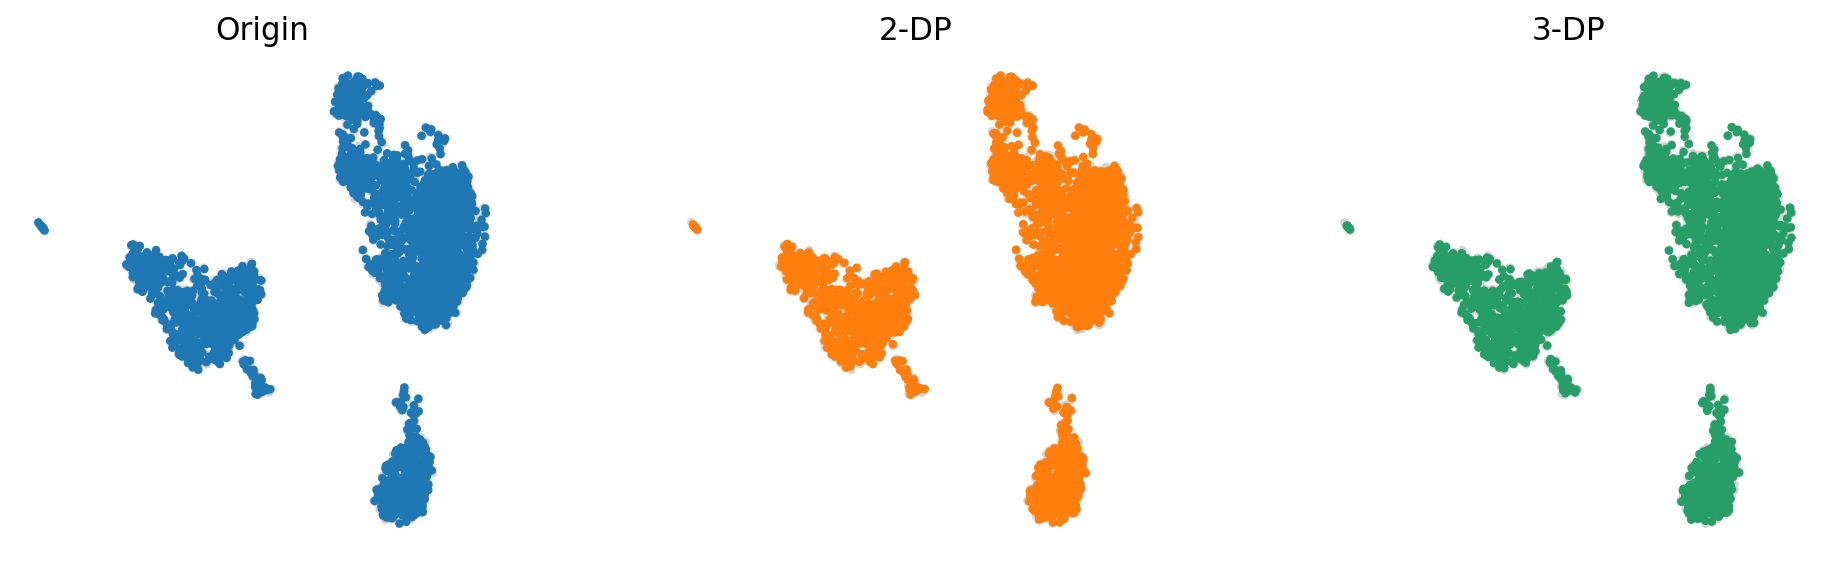

In [ ]:
cluster_small_multiples(ad,'batch',save='pbmc3k_DP_sep.pdf')

# How many HVG
- from 5000 -> 100

10000.0 2.718281828459045 1 [1.9       1.1576178] 132.07318990525653


100%|██████████| 2638/2638 [00:02<00:00, 1300.95it/s]


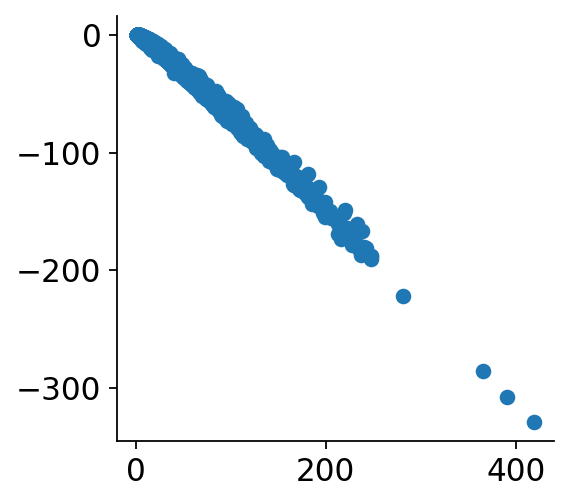

10000.0 2.718281828459045 1 [1.9        1.44055251] 66.4146305146886


100%|██████████| 2638/2638 [00:02<00:00, 1183.36it/s]


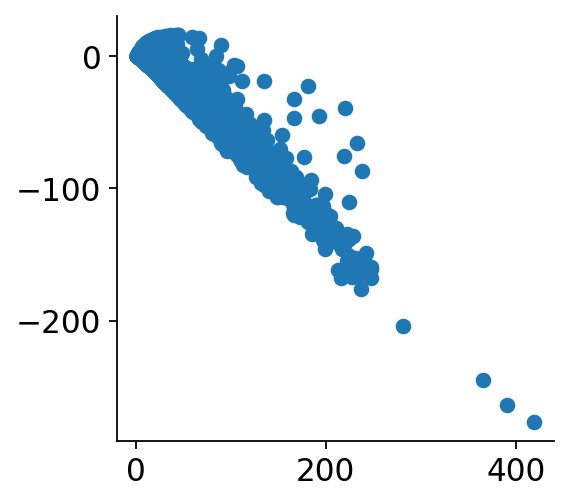

10000.0 2.718281828459045 1 [1.9        1.60834323] 11.748769428720092


100%|██████████| 2638/2638 [00:02<00:00, 1059.73it/s]


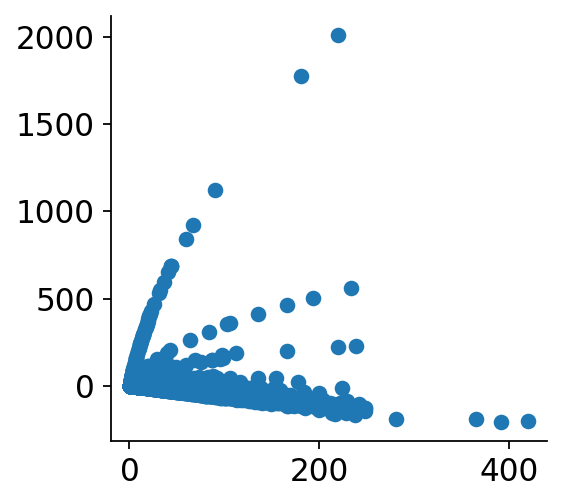

10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:02<00:00, 961.62it/s]


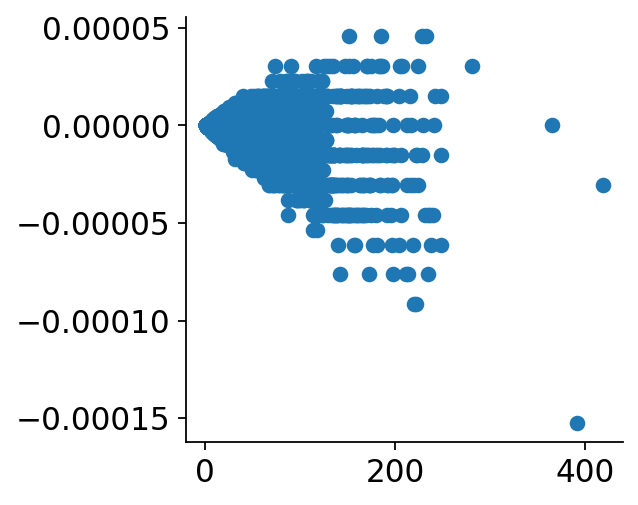

10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:02<00:00, 887.46it/s]


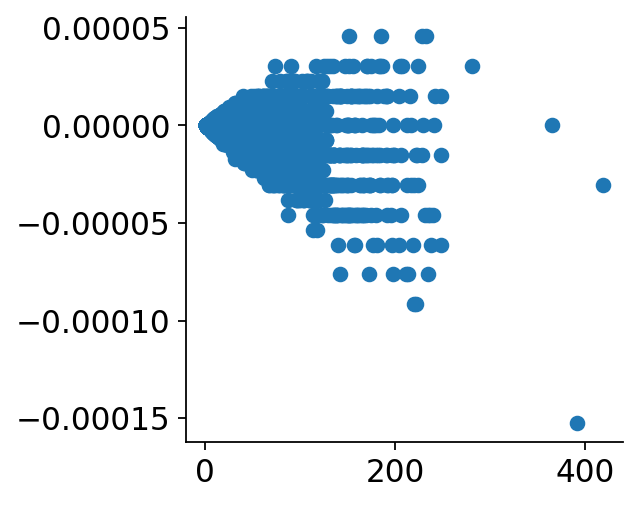

10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:03<00:00, 731.63it/s]


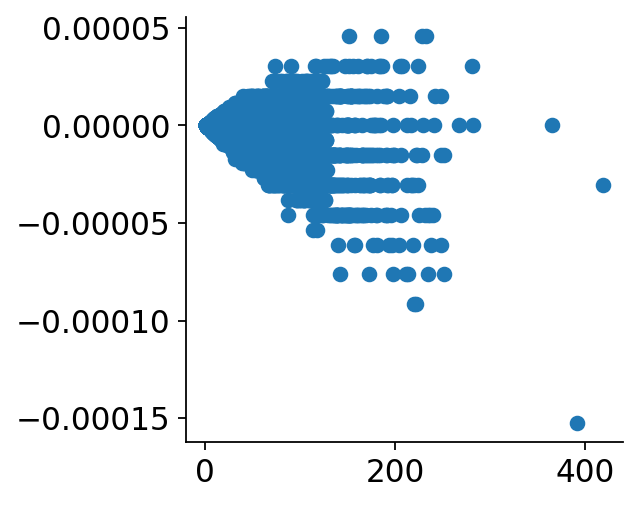

10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:05<00:00, 523.54it/s]


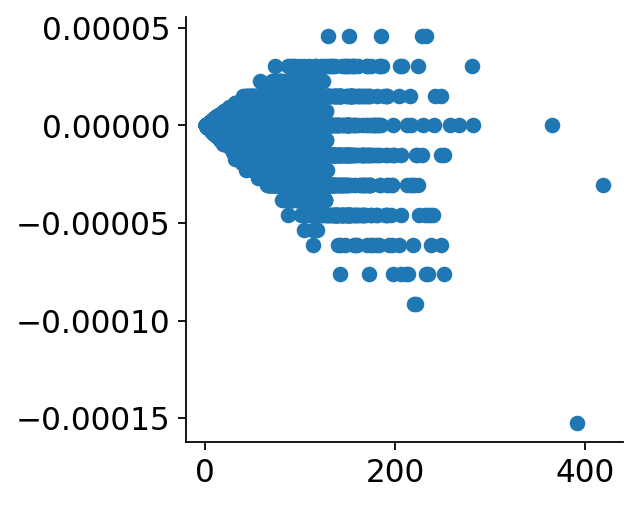

10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:06<00:00, 377.95it/s]


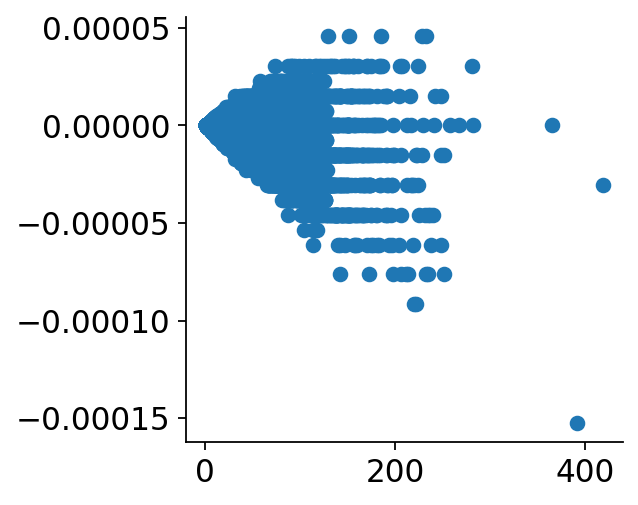

{'bodies': [<matplotlib.collections.PolyCollection>],
 'cmaxes': <matplotlib.collections.LineCollection>,
 'cmins': <matplotlib.collections.LineCollection>,
 'cbars': <matplotlib.collections.LineCollection>}

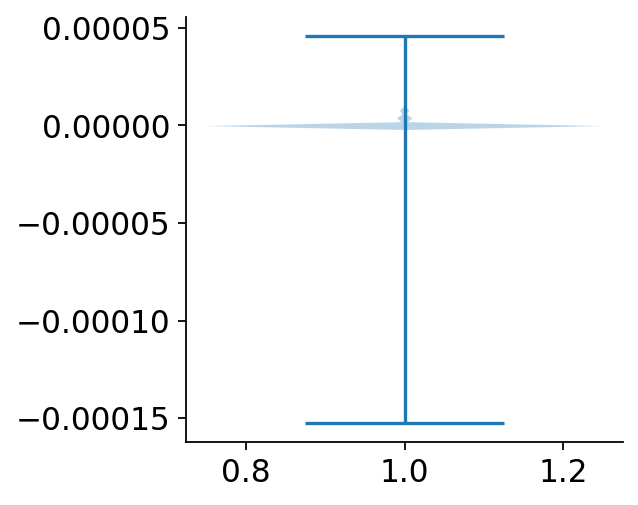

In [ ]:
hh_res,hh_ad,hh_para=[],[],[]
for n in [100,200,300,400,500,1000,2000,5000]:
    ts,b,c=[1e4,np.e,1]
    ad=adata.copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    sc.pp.highly_variable_genes(ad,layer='count', n_top_genes=n,flavor='seurat_v3')
    ad = ad[:, ad.var.highly_variable]
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    hh_para.append([b,c,res.fun])
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
    hh_res.append(res)
    hh_ad.append(new_ad)
    plt.plot(new_ad.layers['count'].data,res,'o')
    plt.show()
plt.violinplot(res,vert=True)

In [ ]:
hh_para=pd.DataFrame(hh_para,columns=['b','c','mse'])

In [ ]:
hh_para['hvg']=[100,200,300,400,500,1000,2000,5000]
hh_para['hvg']=hh_para['hvg'].astype(str).astype('category')

In [ ]:
hh_para['hvg']=hh_para['hvg'].cat.reorder_categories(['100', '200','300', '400', '500','1000', '2000', '5000'][::-1])

In [ ]:
hh_para

b         c           mse   hvg
0  1.900000  1.157618  1.320732e+02   100
1  1.900000  1.440553  6.641463e+01   200
2  1.900000  1.608343  1.174877e+01   300
3  2.718282  1.000000  7.968923e-11   400
4  2.718282  1.000000  7.968923e-11   500
5  2.718282  1.000000  7.968923e-11  1000
6  2.718282  1.000000  7.968923e-11  2000
7  2.718282  1.000000  7.968923e-11  5000

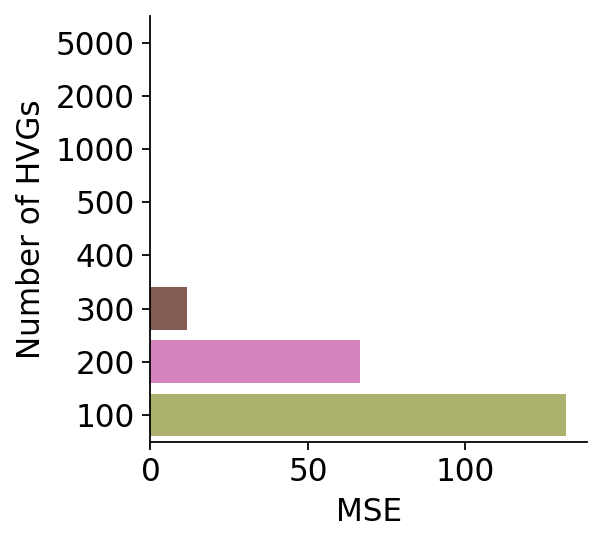

In [ ]:
figsize(3.5,3.5)
sns.barplot(y='hvg',x='mse',data=hh_para)
plt.grid(visible=False)
plt.xlabel('MSE')
plt.ylabel('Number of HVGs')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figures/PBMC/HVG_MSE.pdf',dpi=300, bbox_inches='tight',transparent=True)

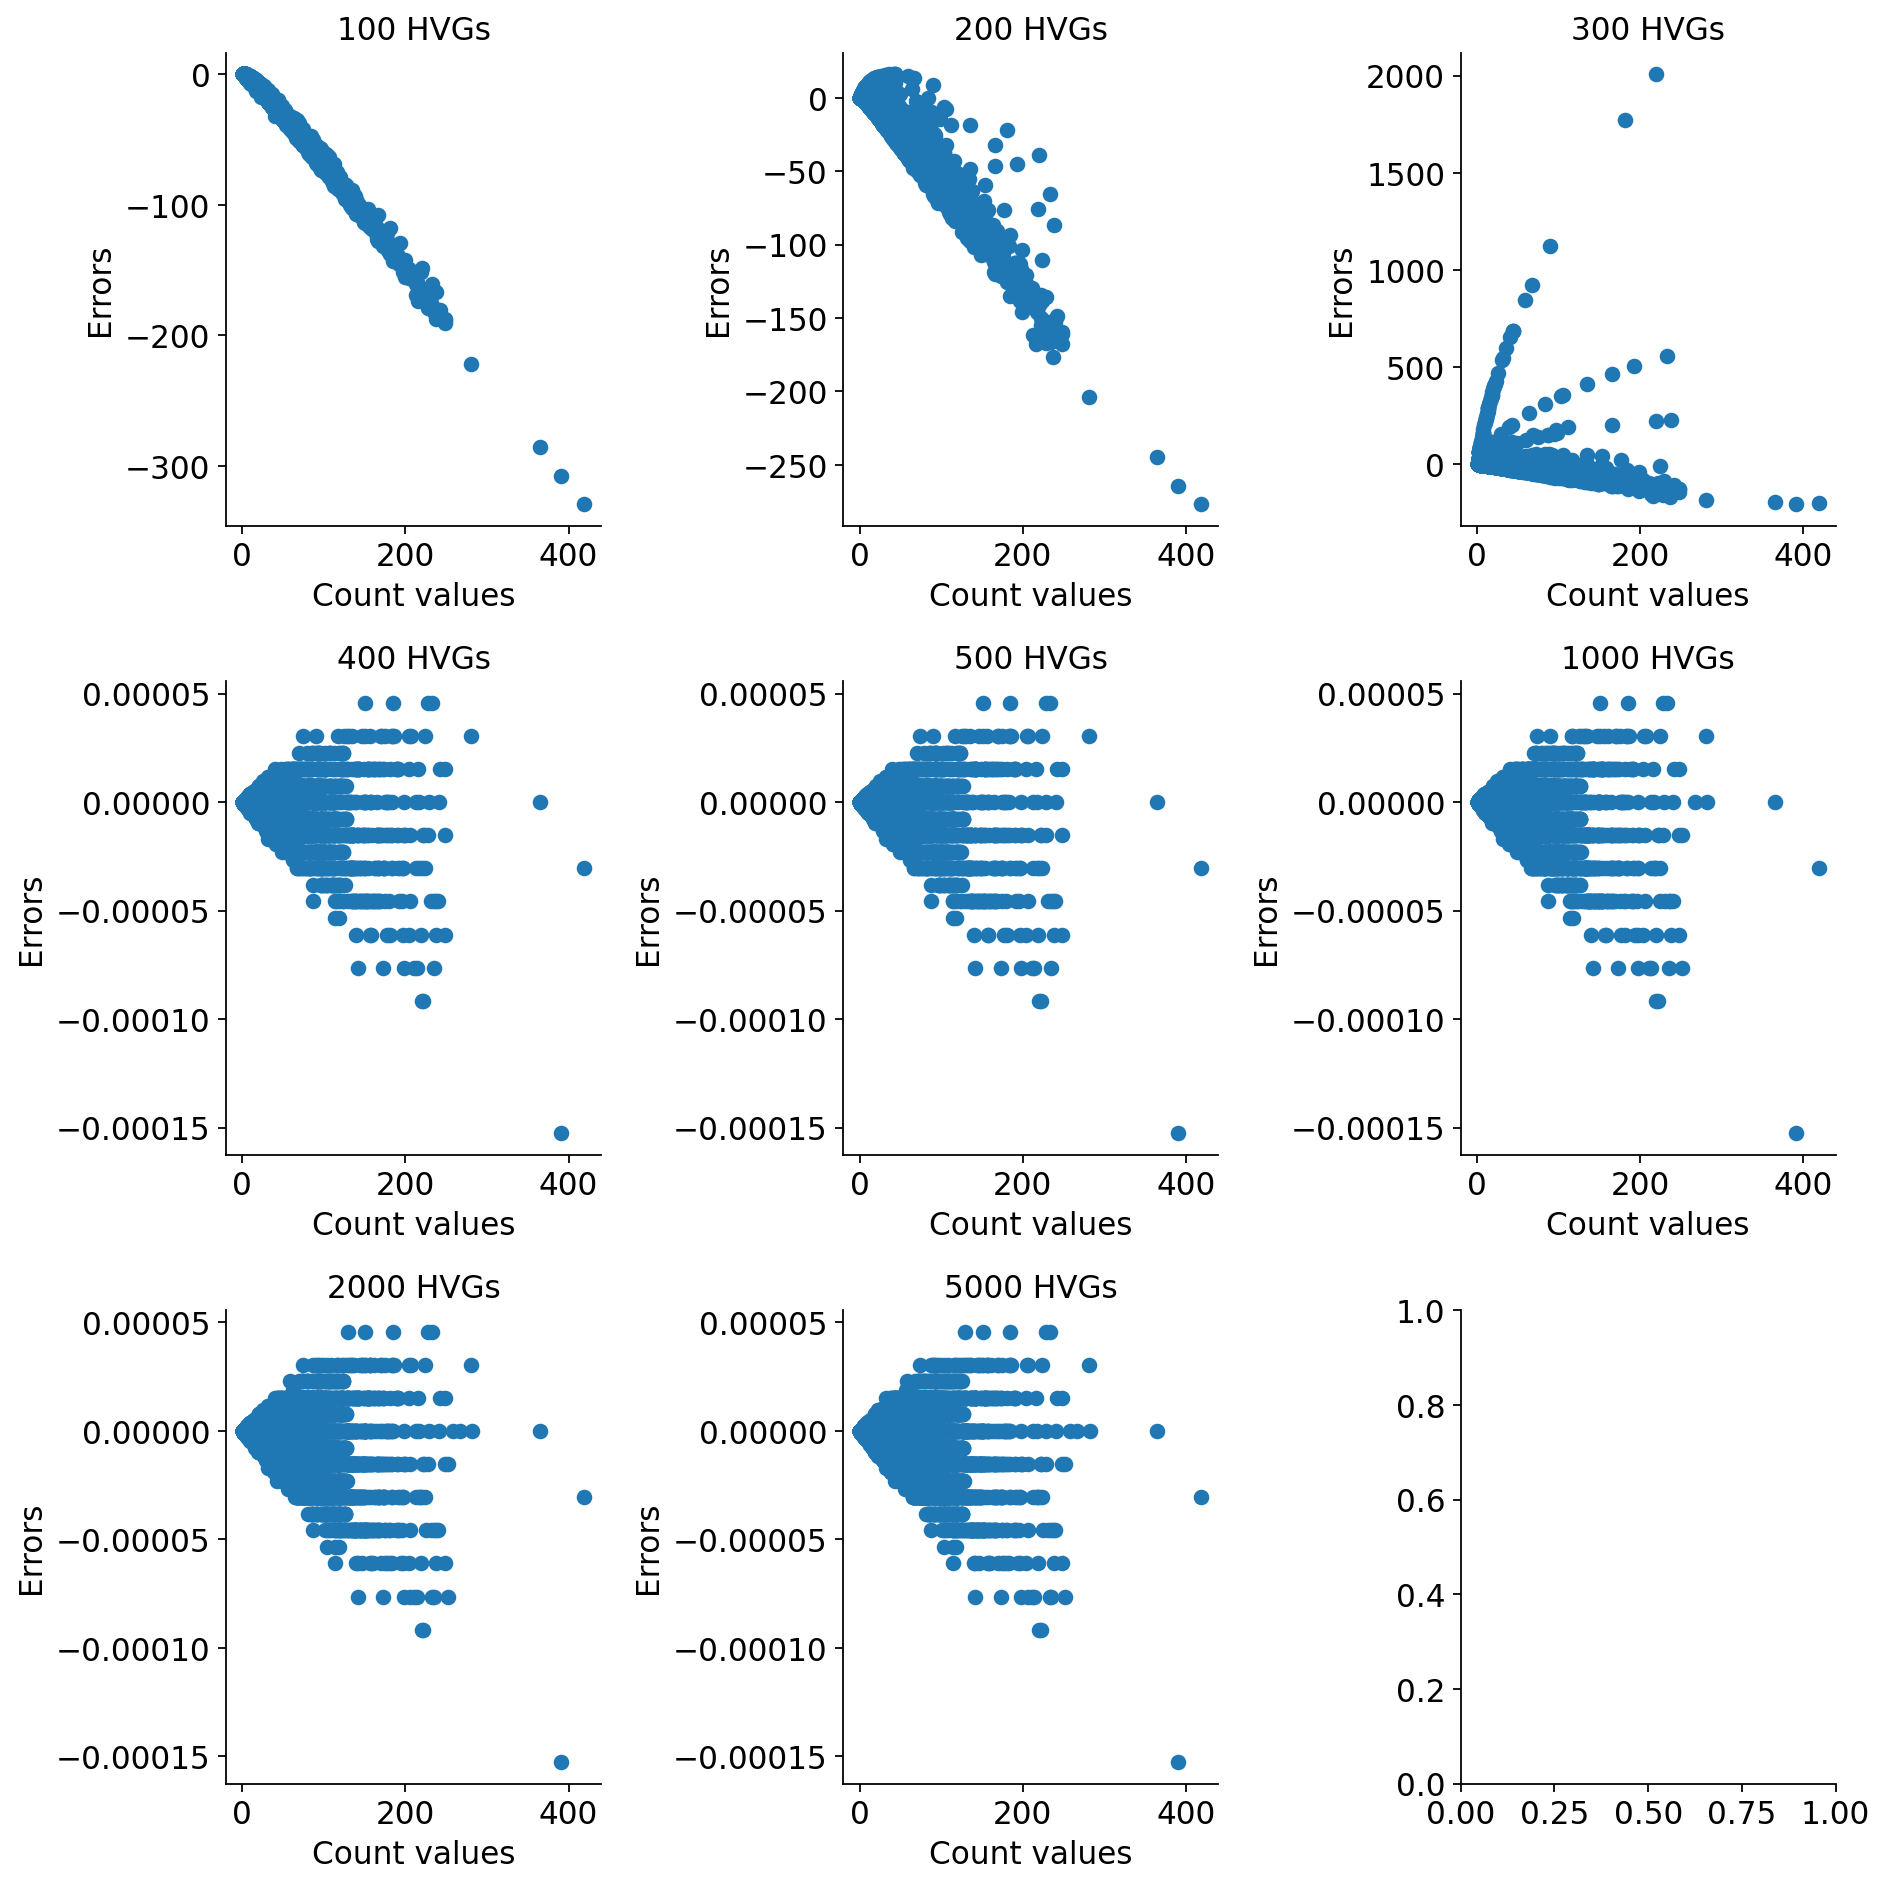

In [ ]:
hvg=[100,200,300,400,500,1000,2000,5000]
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Loop through each subplot and plot the data
for i in range(3):
    for j in range(3):
        try:
            ax = axs[i, j]
            ax.plot(hh_ad[i*3+j].layers['count'].data, hh_res[i*3+j], 'o')
            ax.grid(visible=False)
            ax.set_xlabel('Count values')
            ax.set_ylabel('Errors')
            ax.set_title(str(hvg[i*3+j])+' HVGs')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        except:
            pass

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()